<a href="https://colab.research.google.com/github/zhou100/FoodSecurityPrediction/blob/master/Predict_FS_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use machine learning to predict food security

In [0]:
# Set up Notebook
% matplotlib inline

# Standard imports
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm


# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

 ## Read in the data cleaned out by R

If you are using google colab like me, you will need to mount your google drive first and  copy the cleaned dataset from the R project to your google drive. 
Or in this case where the analysis dataset is small, I can use directly from the Github.

If you are using python/jupyter notebook locally, just point to the right directory. 

In [110]:
# Malawi Data
url = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/mw_dataset_cluster.csv'
mw_clust = pd.read_csv(url)

# Tanzania Data 
url_tz = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/tz_dataset_cluster.csv'
tz_clust = pd.read_csv(url_tz)

# Uganda Data 
url_ug = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/ug_dataset_cluster.csv'
ug_clust = pd.read_csv(url_ug)
ug_clust = ug_clust.replace([np.inf, -np.inf], np.nan)
ug_clust = ug_clust.dropna()

# check for any missing values (should return false)
ug_clust.isnull().values.any()

False

## Preprocessing data


### One-hot encoding for string variables 

In [0]:
mw_clust = mw_clust.drop("FNID",axis =1 )
ug_clust = ug_clust.drop("FNID",axis =1 )

In [0]:
mw_clust["FNID"]= mw_clust["FNID"].str.lstrip('MW2012C')
fnid_mw_clust = pd.get_dummies(mw_clust["FNID"],prefix='MW', drop_first=True)
mw_clust = pd.concat([mw_clust, fnid_mw_clust], axis=1)

### Data preview

In [0]:
mw_clust.head()

,FS_year,FCS,HDDS,rCSI,region_north,region_central,rural,dist_road,dist_admarc,dist_popcenter,percent_ag,nutri_severe_constraint,nutri_moderate_constraint,nutri_reten_severe_constraint,dummy_terrain_rough,FS_month,head_age,female_head,hhsize,floor_dirt_sand_dung,cell_phone,number_celphones,roof_not_natural,roof_iron,asset_index,clust_maize_price,clust_rice_price,clust_nuts_price,clust_beans_price,clust_maize_mktthin,clust_rice_mktthin,clust_nuts_mktthin,clust_beans_mktthin,lhz_maize_price,lhz_rice_price,lhz_nuts_price,lhz_beans_price,lhz_maize_mktthin,lhz_rice_mktthin,lhz_nuts_mktthin,lhz_beans_mktthin,raincytot,day1rain,maxdaysnorain,lhz_day1rain,gdd,tmean,lhz_raincytot,lhz_maxdaysnorain,heatdays,floodmax,lhz_floodmax
0,2010,42.718750,5.375000,2.750000,1.0,0.0,1.000000,2.656875,12.016250,62.406875,20.875000,0.000000,1.000000,0.0,0,4.000000,45.375000,0.187500,5.937500,0.937500,0.250000,0.437500,0.125000,0.125000,-0.409163,44.282500,247.276000,235.426000,187.412000,0.2,0.0,0.0,0.0,51.144094,194.816929,233.930246,167.089217,0.400000,0.4,0.4,0.4,1031.634971,38,97,36,213,21.395283,1127.998114,50,0,1018.117886,0.0
1,2013,41.500000,4.687500,11.625000,1.0,0.0,1.000000,2.250000,12.687500,62.562500,23.250000,0.000000,1.000000,0.0,0,4.000000,47.937500,0.250000,6.187500,0.937500,0.250000,0.250000,0.062500,0.062500,-0.587467,117.495000,338.092614,260.726301,169.705691,0.5,1.0,1.0,1.0,145.347005,390.687644,237.306038,271.791314,0.500000,1.0,1.0,1.0,1108.586041,31,110,31,213,21.984191,1160.837789,74,0,1204.796222,0.0
2,2010,35.218750,4.937500,2.687500,1.0,0.0,1.000000,0.513750,10.821875,58.466875,48.687500,0.000000,1.000000,0.0,0,8.000000,43.187500,0.062500,5.437500,0.875000,0.250000,0.250000,0.187500,0.187500,-0.373761,31.591000,176.821000,180.817000,167.261000,0.0,0.0,0.0,0.0,30.082676,141.357511,92.399333,144.797615,1.000000,1.0,0.8,1.0,1109.109855,38,99,36,213,21.395283,1127.998114,50,0,1039.567553,0.0
3,2010,35.218750,4.937500,2.687500,1.0,0.0,1.000000,0.513750,10.821875,58.466875,48.687500,0.000000,1.000000,0.0,0,8.000000,43.187500,0.062500,5.437500,0.875000,0.250000,0.250000,0.187500,0.187500,-0.373761,31.591000,176.821000,180.817000,167.261000,0.0,0.0,0.0,0.0,30.082676,141.357511,92.399333,144.797615,1.000000,1.0,0.8,1.0,1109.109855,38,99,37,213,22.400072,1134.109696,54,0,1039.567553,0.0
4,2013,48.088235,5.058824,2.411765,1.0,0.0,0.941176,0.529412,11.411765,56.529412,45.764706,0.058824,0.941176,0.0,0,5.058824,45.647059,0.176471,5.529412,0.823529,0.411765,0.647059,0.352941,0.352941,-0.322886,119.627402,400.969080,379.379586,347.946196,0.0,1.0,1.0,1.0,96.706535,257.533827,244.449981,231.704856,0.627451,1.0,1.0,1.0,1179.873268,30,115,31,213,21.984191,1160.837789,74,0,1233.998819,0.0


In [0]:
tz_clust.head()

,FS_year,FCS,HDDS,rCSI,rural,FS_month,region2,region3,region4,region5,region6,region7,region8,region9,region10,region11,region12,region13,region14,region15,region16,region17,region18,region19,region20,region21,region51,region52,region53,region54,region55,dist_road,dist_popcenter,percent_ag,nutri_severe_constraint,nutri_moderate_constraint,nutri_reten_severe_constraint,dummy_terrain_rough,head_age,female_head,asset_index,Cellphone,num_cell,floor_dirt_sand_dung,roof_not_natural,roof_iron,clust_maize_price,clust_rice_price,clust_bean_mktthin,clust_maize_mktthin,clust_rice_mktthin,lhz_maize_price,lhz_rice_price,lhz_bean_mktthin,lhz_maize_mktthin,lhz_rice_mktthin,raincytot,day1rain,maxdaysnorain,lhz_day1rain,gdd,tmean,lhz_raincytot,lhz_maxdaysnorain,heatdays,floodmax,lhz_floodmax
0,2015,43.375000,5.250000,6.125,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.464894,32.893617,32.898936,0.606383,0.313830,0.005319,0,41.375000,0.250000,-0.765501,0.625000,0.875000,0.625000,0.625000,0.625000,27708.0,175833.0,0.0,0.0,0.0,44926.970174,175166.466099,0.0,0.0,0.0,949.138410,5,148,81,213,27.410465,701.392269,142,213,0.0,0.0
1,2015,33.562500,4.500000,17.750,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.464894,32.893617,32.898936,0.606383,0.313830,0.005319,0,46.000000,0.125000,-0.886329,0.500000,0.500000,1.000000,0.000000,0.000000,21731.0,161538.0,0.0,0.0,0.0,38137.865269,156000.969581,0.0,0.0,0.0,948.396418,5,117,81,213,27.410465,701.392269,142,213,0.0,0.0
2,2014,34.000000,4.000000,0.000,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.142582,50.944231,23.662088,0.054945,0.708791,0.000000,0,57.000000,0.000000,-0.583524,0.000000,0.000000,1.000000,1.000000,1.000000,34125.0,154166.5,0.0,0.0,0.0,34493.312488,153017.457084,0.0,0.0,0.0,1008.294152,56,154,56,213,23.074113,1057.404969,122,213,0.0,0.0
3,2015,40.642857,4.142857,2.000,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.142582,50.944231,23.662088,0.054945,0.708791,0.000000,0,44.428571,0.571429,-0.895485,0.857143,1.285714,0.857143,0.571429,0.571429,33000.0,172778.0,0.0,0.0,0.0,33426.151812,171574.642544,0.0,0.0,0.0,946.519706,5,148,51,213,24.746366,779.541637,125,213,0.0,0.0
4,2015,53.625000,5.000000,9.375,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.661765,70.922549,19.411765,0.009804,0.774510,0.000000,0,50.625000,0.250000,0.050865,1.000000,1.875000,0.125000,1.000000,1.000000,33000.0,172778.0,0.0,0.0,0.0,33000.000000,172778.000000,0.0,0.0,0.0,922.248186,5,117,50,213,24.762482,807.468836,123,213,0.0,0.0


In [0]:
ug_clust.head()

,FS_year,FNID,FCS,HDDS,rural,FS_month,region2,region3,region4,dist_road,dist_popcenter,percent_ag,nutri_severe_constraint,nutri_moderate_constraint,nutri_reten_severe_constraint,dummy_terrain_rough,head_age,female_head,asset_index,Cellphone,num_cell,floor_dirt_sand_dung,roof_not_natural,roof_iron,clust_cassava_price,clust_bean_mktthin,clust_maize_mktthin,clust_cassava_mktthin,lhz_cassava_price,lhz_bean_mktthin,lhz_maize_mktthin,lhz_cassava_mktthin,raincytot,day1rain,maxdaysnorain,lhz_day1rain,gdd,tmean,lhz_raincytot,lhz_maxdaysnorain,floodmax,lhz_floodmax
0,2010,UG2011L141,47.5,3.0,0.0,12.0,0.0,0.0,0.0,0.81360,4.09120,22.0,0.0,1.0,0.0,0,31.0,0.0,1.933340,1.0,3.0,0.0,1.0,1.0,600.0,1.0,1.0,0.0,593.592838,1.00000,1.00000,0.000000,474.492036,3,28,3,123,25.129216,558.706113,2,0.0,0.0
1,2011,UG2011L141,20.0,3.0,1.0,1.0,0.0,0.0,0.0,40.43450,65.52810,0.0,0.0,0.0,0.0,0,45.0,0.0,-1.270643,1.0,1.0,1.0,1.0,1.0,900.0,1.0,1.0,0.0,702.971126,1.00000,1.00000,0.028336,1823.754595,3,143,3,488,23.691104,1866.829980,18,0.0,0.0
2,2012,UG2011L137,52.0,5.4,1.0,4.0,0.0,0.0,0.0,24.63892,48.91718,19.8,0.2,0.2,0.2,0,36.2,0.4,-0.033716,0.8,0.8,0.8,1.0,1.0,1193.6,0.0,0.0,0.0,1197.521782,0.01498,0.01498,0.014980,2040.792751,17,40,14,489,23.937279,1939.734309,24,0.0,0.0
3,2012,UG2011L140,52.0,5.4,1.0,4.0,0.0,0.0,0.0,24.63892,48.91718,19.8,0.2,0.2,0.2,0,36.2,0.4,-0.033716,0.8,0.8,0.8,1.0,1.0,1193.6,0.0,0.0,0.0,1197.521782,0.01498,0.01498,0.014980,2040.792751,17,40,5,489,23.030044,1967.415063,22,0.0,0.0
4,2012,UG2011L141,52.0,5.4,1.0,4.0,0.0,0.0,0.0,24.63892,48.91718,19.8,0.2,0.2,0.2,0,36.2,0.4,-0.033716,0.8,0.8,0.8,1.0,1.0,1193.6,0.0,0.0,0.0,1197.521782,0.01498,0.01498,0.014980,2040.792751,17,40,5,489,23.658749,2223.933356,13,0.0,0.0


In [0]:
ug_clust.isnull().values.any()

False

# Methodology


This section will explain our main approach with the data.

1. Focus on categorical prediciton for the given cutoffs. 

Reasons: Close to the actual policy scenarios where we focus on capturing all the insecure households. Recall rate of the insecure villages is more important than the over all accuracy. 

Can apply the down sampling and over sampling technique here to improve 


2.  Algorithms to try : tree classifier, random forest classifier, xgboost 

2.1. By categories, vs one or rest

2.2.  Parameter Tuning

2.3 . feature importance analysis


3.  Error analysis by region, by group, by month

4.  Train model by division separtely Auto-segmentation by training a shallow tree in each country based on observables 

5. Model combination: what happens when we train on all the data 

6. Model generalization issues: what happens when we directly apply  models trained on one country to predict another 







### Continous to categorical (FEWS cutoff)

In [0]:
# cut the outcome variables by the cutoffs
#mw_clust['FCS_category']= pd.cut(x=mw_clust['FCS'], bins=[-1,28,42,100],labels= ["Poor", "Borderline", "Acceptable"])
mw_clust['FCS_category']= pd.cut(x=mw_clust['FCS'], bins=[-1,28,42,100],labels= [2, 1, 0])

 # HDDS 3 and 6
#mw_clust['HDDS_category']= pd.cut(x=mw_clust['HDDS'], bins=[0,3,6,10],labels= ["Low Diversity","Medium Diversity","Good Diversity"])
mw_clust['HDDS_category']= pd.cut(x=mw_clust['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
  

# rCSI 4 and 17  and 42
# mw_clust['rCSI_category']= pd.cut(x=mw_clust['rCSI'], bins=[-1,4,17,42],labels= ["Food Secure","Mildly insecure","Moderately insecure"])
  
mw_clust['rCSI_category']= pd.cut(x=mw_clust['rCSI'], bins=[-1,4,17,50],labels= [0, 1, 2])

# cut the outcome variables by the cutoffs
tz_clust['FCS_category']= pd.cut(x=tz_clust['FCS'], bins=[-1,28,42,200],labels= [2, 1, 0])

# HDDS 3 and 6
tz_clust['HDDS_category']= pd.cut(x=tz_clust['HDDS'], bins=[-1,3,6,20],labels= [2, 1, 0])

# rCSI 4 and 17  and 42
tz_clust['rCSI_category']= pd.cut(x=tz_clust['rCSI'], bins=[-1,4,17,50],labels= [0, 1, 2])

# cut the outcome variables by the cutoffs
ug_clust['FCS_category']= pd.cut(x=ug_clust['FCS'], bins=[-1,28,42,200],labels= [2, 1, 0])

ug_clust['HDDS_category']= pd.cut(x=ug_clust['HDDS'], bins=[-1,3,6,20],labels= [2, 1, 0])


In [6]:
print(tz_clust['FCS_category'].value_counts())
print(tz_clust['HDDS_category'].value_counts())
print(tz_clust['rCSI_category'].value_counts())

print(mw_clust['FCS_category'].value_counts())
print(mw_clust['HDDS_category'].value_counts())
print(mw_clust['rCSI_category'].value_counts())

print(ug_clust['FCS_category'].value_counts())
print(ug_clust['HDDS_category'].value_counts())

0    2146
1     467
2      39
Name: FCS_category, dtype: int64
1    2134
0     500
2      18
Name: HDDS_category, dtype: int64
0    1600
1    1004
2      48
Name: rCSI_category, dtype: int64
0    2008
1     597
2      14
Name: FCS_category, dtype: int64
1    2078
0     539
2       2
Name: HDDS_category, dtype: int64
0    1813
1     799
2       7
Name: rCSI_category, dtype: int64
0    913
1    412
2     53
Name: FCS_category, dtype: int64
1    1260
0     101
2      17
Name: HDDS_category, dtype: int64


### Binary cutoff

In [0]:
# cut the outcome variables by the cutoffs
mw_clust['FCS_category']= pd.cut(x=mw_clust['FCS'], bins=[-1,42,100],labels= [1, 0])

 # HDDS 3 and 6
mw_clust['HDDS_category']= pd.cut(x=mw_clust['HDDS'], bins=[0,6,10],labels= [1, 0])
  

# rCSI 4 and 17  and 42
# mw_clust['rCSI_category']= pd.cut(x=mw_clust['rCSI'], bins=[-1,4,17,42],labels= ["Food Secure","Mildly insecure","Moderately insecure"])
  
mw_clust['rCSI_category']= pd.cut(x=mw_clust['rCSI'], bins=[-1,4,42],labels= [0, 1])


# cut the outcome variables by the cutoffs
tz_clust['FCS_category']= pd.cut(x=tz_clust['FCS'], bins=[-1,42,200],labels= [1, 0])

 # HDDS 3 and 6
tz_clust['HDDS_category']= pd.cut(x=tz_clust['HDDS'], bins=[0,6,10],labels= [1, 0])
  

# rCSI 4 and 17  and 42
# tz_clust['rCSI_category']= pd.cut(x=tz_clust['rCSI'], bins=[-1,4,17,42],labels= ["Food Secure","Mildly insecure","Moderately insecure"])
  
tz_clust['rCSI_category']= pd.cut(x=tz_clust['rCSI'], bins=[-1,4,42],labels= [0, 1])


# cut the outcome variables by the cutoffs
ug_clust['FCS_category']= pd.cut(x=ug_clust['FCS'], bins=[-1,42,200],labels= [1, 0])

 # HDDS 3 and 6
ug_clust['HDDS_category']= pd.cut(x=ug_clust['HDDS'], bins=[0,6,10],labels= [1, 0])
  




In [0]:
np.where(tz_clust['FCS_category'].isnull()) 

(array([], dtype=int64),)

## Exploratory Data Analysis  

### Pie plots to show class balance

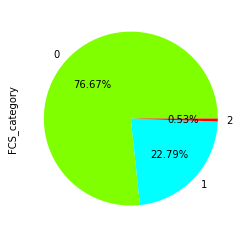

In [0]:
mw_clust['FCS_category'].value_counts().plot(kind='pie', title='',autopct = "%.2f%%", colors = ['chartreuse', 'aqua','red'])

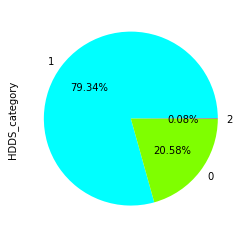

In [0]:
mw_clust['HDDS_category'].value_counts().plot(kind='pie', title='',autopct = "%.2f%%", colors = ['aqua','chartreuse','red'])

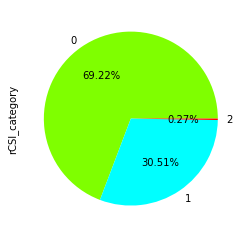

In [0]:
mw_clust['rCSI_category'].value_counts().plot(kind='pie', title='',autopct = "%.2f%%", colors = ['chartreuse','aqua','red'])

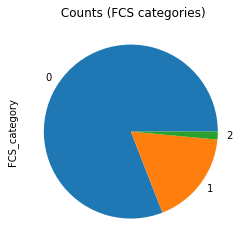

In [0]:
tz_clust['FCS_category'].value_counts().plot(kind='pie', title=' Counts (FCS categories)')

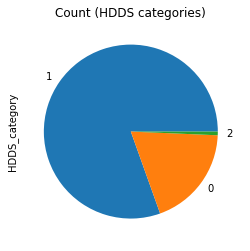

In [0]:
tz_clust['HDDS_category'].value_counts().plot(kind='pie', title='Count (HDDS categories)')

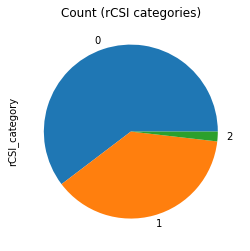

In [0]:
tz_clust['rCSI_category'].value_counts().plot(kind='pie', title='Count (rCSI categories)')

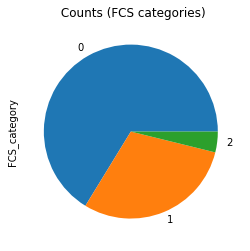

In [0]:
ug_clust['FCS_category'].value_counts().plot(kind='pie', title=' Counts (FCS categories)')


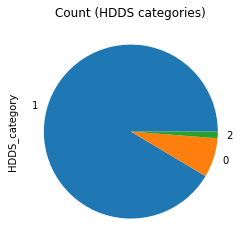

In [0]:
# HDDS 3 and 6
ug_clust['HDDS_category'].value_counts().plot(kind='pie', title='Count (HDDS categories)')


## Split train and test data

 For practical prediction purposes,  we use the most recent round of survey data  as the testing  and the rest as the training data. 


### Year split 

In [7]:
 mw_clust['FS_year'].value_counts()

2010    1175
2013     805
2016     445
2011     194
Name: FS_year, dtype: int64

In [0]:
 tz_clust['FS_year'].value_counts()

2013    834
2011    787
2012    391
2015    311
2010    254
2014     75
Name: FS_year, dtype: int64

In [0]:
 ug_clust['FS_year'].value_counts()

2011    536
2012    440
2010    402
Name: FS_year, dtype: int64

In [0]:
mw_clust_test_cond_16 =  mw_clust['FS_year']>2015
mw_clust_train_cond_16 =  mw_clust['FS_year']<2016

mw_clust_test_cond_13 =  mw_clust['FS_year']==2013
mw_clust_train_cond_13 =  mw_clust['FS_year']!=2013

mw_clust_test_cond_11 =  mw_clust['FS_year'] <2013
mw_clust_train_cond_11 =  mw_clust['FS_year'] >2011

mw_clust_test_16 = mw_clust[mw_clust_test_cond_16]
mw_clust_train_16 = mw_clust[mw_clust_train_cond_16]

mw_clust_test_13 = mw_clust[mw_clust_test_cond_13]
mw_clust_train_13 = mw_clust[mw_clust_train_cond_13]

mw_clust_test_11 = mw_clust[mw_clust_test_cond_11]
mw_clust_train_11 = mw_clust[mw_clust_train_cond_11]

# Tanzania 
tz_clust_test_cond_15 =  tz_clust['FS_year']>2013
tz_clust_train_cond_15 =  tz_clust['FS_year']<2014

tz_clust_test_cond_12=  (tz_clust['FS_year'] == 2012) | (tz_clust['FS_year'] == 2013)
tz_clust_train_cond_12=  (tz_clust['FS_year'] != 2012) & (tz_clust['FS_year'] != 2013)

tz_clust_test_cond_10 =  tz_clust['FS_year']<2012
tz_clust_train_cond_10=  tz_clust['FS_year']>2012

tz_clust_test_15 = tz_clust[tz_clust_test_cond_15]
tz_clust_train_15 = tz_clust[tz_clust_train_cond_15]

tz_clust_test_12 = tz_clust[tz_clust_test_cond_12]
tz_clust_train_12 = tz_clust[tz_clust_train_cond_12]

tz_clust_test_10 = tz_clust[tz_clust_test_cond_10]
tz_clust_train_10 = tz_clust[tz_clust_train_cond_10]


# Uganda 
ug_clust_test_cond_12 =  ug_clust['FS_year']>2011
ug_clust_train_cond_12 =  ug_clust['FS_year']<2012

ug_clust_test_cond_11 =  ug_clust['FS_year']==2011
ug_clust_train_cond_11 =  ug_clust['FS_year']!=2011

ug_clust_test_cond_10 =  ug_clust['FS_year']==2010
ug_clust_train_cond_10 =  ug_clust['FS_year']!=2010 

ug_clust_test_12 = ug_clust[ug_clust_test_cond_12]
ug_clust_train_12 = ug_clust[ug_clust_train_cond_12]

ug_clust_test_11 = ug_clust[ug_clust_test_cond_11]
ug_clust_train_11 = ug_clust[ug_clust_train_cond_11]

ug_clust_test_10 = ug_clust[ug_clust_test_cond_10]
ug_clust_train_10 = ug_clust[ug_clust_train_cond_10]


In [0]:
# Define label variables  
labels = ['FCS', 'rCSI', 'HDDS']
category_labels = ['FCS_category', 'rCSI_category', 'HDDS_category']

# Separate y and X

mw_clust_y_train_11= mw_clust_train_11[['FCS_category', 'rCSI_category', 'HDDS_category']]
mw_clust_y_test_11= mw_clust_test_11[['FCS_category', 'rCSI_category', 'HDDS_category']]
mw_clust_y_train_13= mw_clust_train_13[['FCS_category', 'rCSI_category', 'HDDS_category']]
mw_clust_y_test_13= mw_clust_test_13[['FCS_category', 'rCSI_category', 'HDDS_category']]
mw_clust_y_train_16= mw_clust_train_16[['FCS_category', 'rCSI_category', 'HDDS_category']]
mw_clust_y_test_16= mw_clust_test_16[['FCS_category', 'rCSI_category', 'HDDS_category']]

mw_clust_X_test_11= mw_clust_test_11.drop(labels+category_labels,  axis=1)
mw_clust_X_train_11= mw_clust_train_11.drop(labels+category_labels, axis=1)
mw_clust_X_test_13= mw_clust_test_13.drop(labels+category_labels,  axis=1)
mw_clust_X_train_13= mw_clust_train_13.drop(labels+category_labels, axis=1)
mw_clust_X_test_16= mw_clust_test_16.drop(labels+category_labels,  axis=1)
mw_clust_X_train_16= mw_clust_train_16.drop(labels+category_labels, axis=1)

tz_clust_y_train_10= tz_clust_train_10[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_clust_y_test_10= tz_clust_test_10[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_clust_y_train_12= tz_clust_train_12[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_clust_y_test_12= tz_clust_test_12[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_clust_y_train_15= tz_clust_train_15[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_clust_y_test_15= tz_clust_test_15[['FCS_category', 'rCSI_category', 'HDDS_category']]

tz_clust_X_test_10= tz_clust_test_10.drop(labels+category_labels,  axis=1)
tz_clust_X_train_10= tz_clust_train_10.drop(labels+category_labels, axis=1)
tz_clust_X_test_12= tz_clust_test_12.drop(labels+category_labels,  axis=1)
tz_clust_X_train_12= tz_clust_train_12.drop(labels+category_labels, axis=1)
tz_clust_X_test_15= tz_clust_test_15.drop(labels+category_labels,  axis=1)
tz_clust_X_train_15= tz_clust_train_15.drop(labels+category_labels, axis=1)

ug_labels = ['FCS', 'HDDS']
ug_category_labels = ['FCS_category', 'HDDS_category']


ug_clust_y_train_11= ug_clust_train_11[['FCS_category', 'HDDS_category']]
ug_clust_y_test_11= ug_clust_test_11[['FCS_category',  'HDDS_category']]
ug_clust_y_train_10= ug_clust_train_10[['FCS_category', 'HDDS_category']]
ug_clust_y_test_10= ug_clust_test_10[['FCS_category', 'HDDS_category']]
ug_clust_y_train_12= ug_clust_train_12[['FCS_category', 'HDDS_category']]
ug_clust_y_test_12= ug_clust_test_12[['FCS_category', 'HDDS_category']]

ug_clust_X_test_11= ug_clust_test_11.drop(ug_labels+ug_category_labels,  axis=1)
ug_clust_X_train_11= ug_clust_train_11.drop(ug_labels+ug_category_labels, axis=1)
ug_clust_X_test_10= ug_clust_test_10.drop(ug_labels+ug_category_labels,  axis=1)
ug_clust_X_train_10= ug_clust_train_10.drop(ug_labels+ug_category_labels, axis=1)
ug_clust_X_test_12= ug_clust_test_12.drop(ug_labels+ug_category_labels,  axis=1)
ug_clust_X_train_12= ug_clust_train_12.drop(ug_labels+ug_category_labels, axis=1)



### Region split

In [0]:
mw_clust_test_cond_region =  mw_clust['region_central']>0.7
mw_clust_train_cond_region =  mw_clust['region_central']<0.7

mw_clust_test_region = mw_clust[mw_clust_test_cond_region]
mw_clust_train_region = mw_clust[mw_clust_train_cond_region]



In [0]:
ug_clust_test_cond_region1 =  ug_clust['region4']==0 
ug_clust_test_cond_region2 =  ug_clust['region3']==0 
ug_clust_test_cond_region3 =  ug_clust['region2']==0 

ug_clust_train_cond_region1 =  ug_clust['region4']!=0 
ug_clust_train_cond_region2 =  ug_clust['region3']!=0 
ug_clust_train_cond_region3 =  ug_clust['region2']!=0 


ug_clust_test_region = ug_clust[ug_clust_test_cond_region1 & ug_clust_test_cond_region2 & ug_clust_test_cond_region3]
ug_clust_train_region = ug_clust[ ug_clust_train_cond_region1 | ug_clust_train_cond_region2 | ug_clust_train_cond_region3 ]


In [0]:
ug_clust_test_region.shape

(450, 43)

In [0]:


# Define label variables  
labels = ['FCS', 'rCSI', 'HDDS']
category_labels = ['FCS_category', 'rCSI_category', 'HDDS_category']


# Separate y and X

mw_clust_y_train_region= mw_clust_train_region[['FCS_category', 'rCSI_category', 'HDDS_category']]
mw_clust_y_test_region= mw_clust_test_region[['FCS_category', 'rCSI_category', 'HDDS_category']]
 
mw_clust_X_test_region= mw_clust_test_region.drop(labels+category_labels+['FNID'],  axis=1)
mw_clust_X_train_region= mw_clust_train_region.drop(labels+category_labels+['FNID'], axis=1)


 

ug_clust_y_train_region= ug_clust_train_region[['FCS_category', 'HDDS_category']]
ug_clust_y_test_region= ug_clust_test_region[['FCS_category', 'HDDS_category']]

ug_clust_X_test_region= ug_clust_test_region.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],  axis=1)
ug_clust_X_train_region= ug_clust_train_region.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],axis=1)
 

### Random split

In [0]:
### Random split

from sklearn.model_selection import train_test_split

y_mw = mw_clust[['FCS_category', 'rCSI_category', 'HDDS_category']]
X_mw = mw_clust.drop(labels+category_labels+['FNID'],  axis=1)

X_train_mw, X_test_mw, y_train_mw, y_test_mw = train_test_split(X_mw, y_mw, test_size=0.33, random_state=42)

y_ug = ug_clust[['FCS_category', 'HDDS_category']]
X_ug = ug_clust.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category','FNID'],  axis=1)

X_train_ug, X_test_ug, y_train_ug, y_test_ug = train_test_split(X_ug, y_ug, test_size=0.33, random_state=42)


## Models



### Define models

In [0]:
from sklearn.linear_model import LogisticRegression


def LRCLF(X_train,y_train,X_test, y_test):

    lr_clf = LogisticRegression(random_state=66, solver='lbfgs',
                              multi_class='multinomial')
    lr_clf.fit(X_train, y_train)

    y_pred = lr_clf.predict(X_test)
    # y_prob = lr_clf.predict_proba(X_test)[:, 1]

    return y_pred,y_test
    # return y_prob,y_test


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


def TreeCLF(X_train,y_train,X_test, y_test):
    # Define tree classifier
    tree_clf = DecisionTreeClassifier(random_state=66)
    
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
    # n_estimators = [int(x) for x in np.linspace(1, 10, num = 5)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    tree_random = RandomizedSearchCV(estimator = tree_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    tree_random.fit( X_train, y_train)

    y_pred = tree_random.predict(X_test)
    
    # y_prob = tree_random.predict_proba(X_test)[:, 1]
    
    
    return y_pred,y_test
    # return y_prob,y_test

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


def rfCLF(X_train,y_train,X_test, y_test):

    rf_clf = RandomForestClassifier(max_features='auto', n_estimators = 100,min_samples_split=10,warm_start=True)

        
    # Define rfc classifier
    max_depth = [int(x) for x in np.linspace(12, 30, num = 10)]
    max_features = [int(x) for x in np.linspace(8, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)
  
    y_pred = rf_random.predict(X_test)
 
    #y_prob = rf_random.predict_proba(X_test)[:, 1]
    
    return y_pred,y_test
    # return y_prob,y_test

In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


def XGBCLF(X_train,y_train,X_test, y_test):

    # fit model on  training data
    XGB_clf = XGBClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.3,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          #objective='multi:softmax', 
                          #num_class=14,
                          n_estimators=100, 
                          reg_alpha = 0.3,
                          max_depth=5, 
                          gamma=10)
    
    max_depth = [int(x) for x in np.linspace(2, 5, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    XGB_random = RandomizedSearchCV(estimator = XGB_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)
    # Fit the random search model
    XGB_random.fit(X_train.as_matrix(), y_train)


   
    
    y_pred = XGB_random.predict(X_test.as_matrix())
    
    # y_prob = XGB_random.predict_proba(X_test.values)[:, 1]

    return y_pred,y_test

    #return y_prob,y_test


## Define Measurement

### Confusion matrix 

In [0]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def pre_rec_f1_support_minority(y_pred,y_test):

  if len(precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3])==3:
    precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][2]
    recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][2]
    fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][2]
    support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][2]

  elif len(precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3])==2:
    precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][1]
    recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][1]
    fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][1]
    support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][1]

  accuracy = accuracy_score(y_pred,y_test)

  return precision,recall,fscore,support,accuracy    
 

### ROC curvese
ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate
ROC curves are typically used in binary classification to study the output of a 

classifier. In order to extend ROC curve and ROC area to multi-class or multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

## Results

### Baseline Model results

In [70]:
from sklearn.metrics import precision_recall_fscore_support
y_pred,y_test  = LRCLF (mw_clust_X_train_11,mw_clust_y_train_11['FCS_category'], mw_clust_X_test_11,mw_clust_y_test_11['FCS_category'] )
#precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.98      0.84       993
           1       0.54      0.08      0.14       362
           2       0.00      0.00      0.00        14

    accuracy                           0.73      1369
   macro avg       0.43      0.35      0.33      1369
weighted avg       0.68      0.73      0.65      1369



In [71]:
print ("Malawi baseline Results")

# mw11
y_pred,y_test  = LRCLF (mw_clust_X_train_11,mw_clust_y_train_11['FCS_category'], mw_clust_X_test_11,mw_clust_y_test_11['FCS_category'] )
precision_mw11_fcs,recall_mw11_fcs,fscore_mw11_fcs,support_mw11_fcs,accuracy_mw11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = LRCLF (mw_clust_X_train_11,mw_clust_y_train_11['rCSI_category'], mw_clust_X_test_11,mw_clust_y_test_11['rCSI_category'] )
precision_mw11_rCSI,recall_mw11_rCSI,fscore_mw11_rCSI,support_mw11_rCSI,accuracy_mw11_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# mw13

y_pred,y_test  = LRCLF (mw_clust_X_train_13,mw_clust_y_train_13['FCS_category'], mw_clust_X_test_13,mw_clust_y_test_13['FCS_category'] )
precision_mw13_fcs,recall_mw13_fcs,fscore_mw13_fcs,support_mw13_fcs,accuracy_mw13_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = LRCLF (mw_clust_X_train_13,mw_clust_y_train_13['rCSI_category'], mw_clust_X_test_13,mw_clust_y_test_13['rCSI_category'] )
precision_mw13_rCSI,recall_mw13_rCSI,fscore_mw13_rCSI,support_mw13_rCSI,accuracy_mw13_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# mw16


y_pred,y_test  = LRCLF (mw_clust_X_train_16,mw_clust_y_train_16['FCS_category'], mw_clust_X_test_16,mw_clust_y_test_16['FCS_category'] )
precision_mw16_fcs,recall_mw16_fcs,fscore_mw16_fcs,support_mw16_fcs,accuracy_mw16_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = LRCLF (mw_clust_X_train_16,mw_clust_y_train_16['rCSI_category'], mw_clust_X_test_16,mw_clust_y_test_16['rCSI_category'] )
precision_mw16_rCSI,recall_mw16_rCSI,fscore_mw16_rCSI,support_mw16_rCSI,accuracy_mw16_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

print ("Tanzania baseline Results")


# tz 10
y_pred,y_test  = LRCLF (tz_clust_X_train_10,tz_clust_y_train_10['FCS_category'], tz_clust_X_test_10,tz_clust_y_test_10['FCS_category'] )
precision_tz10_fcs,recall_tz10_fcs,fscore_tz10_fcs,support_tz10_fcs,accuracy_tz10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = LRCLF (tz_clust_X_train_10,tz_clust_y_train_10['rCSI_category'], tz_clust_X_test_10,tz_clust_y_test_10['rCSI_category'] )
precision_tz10_rCSI,recall_tz10_rCSI,fscore_tz10_rCSI,support_tz10_rCSI,accuracy_tz10_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# tz 12

y_pred,y_test  = LRCLF (tz_clust_X_train_12,tz_clust_y_train_12['FCS_category'], tz_clust_X_test_12,tz_clust_y_test_12['FCS_category'] )
precision_tz12_fcs,recall_tz12_fcs,fscore_tz12_fcs,support_tz12_fcs,accuracy_tz12_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = LRCLF (tz_clust_X_train_12,tz_clust_y_train_12['rCSI_category'], tz_clust_X_test_12,tz_clust_y_test_12['rCSI_category'] )
precision_tz12_rCSI,recall_tz12_rCSI,fscore_tz12_rCSI,support_tz12_rCSI,accuracy_tz12_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# tz 15
y_pred,y_test  = LRCLF (tz_clust_X_train_15,tz_clust_y_train_15['FCS_category'], tz_clust_X_test_15,tz_clust_y_test_15['FCS_category'] )
precision_tz15_fcs,recall_tz15_fcs,fscore_tz15_fcs,support_tz15_fcs,accuracy_tz15_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = LRCLF (tz_clust_X_train_15,tz_clust_y_train_15['rCSI_category'], tz_clust_X_test_15,tz_clust_y_test_15['rCSI_category'] )
precision_tz15_rCSI,recall_tz15_rCSI,fscore_tz15_rCSI,support_tz15_rCSI,accuracy_tz15_rCSI = pre_rec_f1_support_minority(y_pred,y_test)



print ("Uganda baseline Results")

#ug 10
y_pred,y_test  = LRCLF (ug_clust_X_train_10,ug_clust_y_train_10['FCS_category'], ug_clust_X_test_10,ug_clust_y_test_10['FCS_category'] )
precision_ug10_fcs,recall_ug10_fcs,fscore_ug10_fcs,support_ug10_fcs,accuracy_ug10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 11
y_pred,y_test  = LRCLF (ug_clust_X_train_11,ug_clust_y_train_11['FCS_category'], ug_clust_X_test_11,ug_clust_y_test_11['FCS_category'] )
precision_ug11_fcs,recall_ug11_fcs,fscore_ug11_fcs,support_ug11_fcs,accuracy_ug11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 12
y_pred,y_test  = LRCLF (ug_clust_X_train_12,ug_clust_y_train_12['FCS_category'], ug_clust_X_test_12,ug_clust_y_test_12['FCS_category'] )
precision_ug12_fcs,recall_ug12_fcs,fscore_ug12_fcs,support_ug12_fcs,accuracy_ug12_fcs = pre_rec_f1_support_minority(y_pred,y_test)





Malawi baseline Results
Tanzania baseline Results
Uganda baseline Results


In [0]:
# create averages 

# FCS
mw_fcs_precision = sum([precision_mw11_fcs,precision_mw13_fcs,precision_mw16_fcs])/3

mw_fcs_recall = sum([recall_mw11_fcs,recall_mw13_fcs,recall_mw16_fcs])/3

mw_fcs_fscore = sum([fscore_mw11_fcs,fscore_mw13_fcs,fscore_mw16_fcs])/3

mw_fcs_support = sum([support_mw11_fcs,support_mw13_fcs,support_mw16_fcs])/3

mw_fcs_accuracy = sum([accuracy_mw11_fcs,accuracy_mw13_fcs,accuracy_mw16_fcs])/3



tz_fcs_precision = sum([precision_tz10_fcs,precision_tz12_fcs,precision_tz15_fcs])/3

tz_fcs_recall = sum([recall_tz10_fcs,recall_tz12_fcs,recall_tz15_fcs])/3

tz_fcs_fscore = sum([fscore_tz10_fcs,fscore_tz12_fcs,fscore_tz15_fcs])/3

tz_fcs_support = sum([support_tz10_fcs,support_tz12_fcs,support_tz15_fcs])/3

tz_fcs_accuracy = sum([accuracy_tz10_fcs,accuracy_tz12_fcs,accuracy_tz15_fcs])/3


ug_fcs_precision = sum([precision_ug10_fcs,precision_ug12_fcs,precision_ug11_fcs])/3

ug_fcs_recall = sum([recall_ug10_fcs,recall_ug12_fcs,recall_ug11_fcs])/3

ug_fcs_fscore = sum([fscore_ug10_fcs,fscore_ug12_fcs,fscore_ug11_fcs])/3

ug_fcs_support = sum([support_ug10_fcs,support_ug12_fcs,support_ug11_fcs])/3

ug_fcs_accuracy = sum([accuracy_ug10_fcs,accuracy_ug12_fcs,accuracy_ug11_fcs])/3

# rCSI 

mw_rCSI_precision = sum([precision_mw11_rCSI,precision_mw13_rCSI,precision_mw16_rCSI])/3

mw_rCSI_recall = sum([recall_mw11_rCSI,recall_mw13_rCSI,recall_mw16_rCSI])/3

mw_rCSI_fscore = sum([fscore_mw11_rCSI,fscore_mw13_rCSI,fscore_mw16_rCSI])/3

mw_rCSI_support = sum([support_mw11_rCSI,support_mw13_rCSI,support_mw16_rCSI])/3

mw_rCSI_accuracy = sum([accuracy_mw11_rCSI,accuracy_mw13_rCSI,accuracy_mw16_rCSI])/3



tz_rCSI_precision = sum([precision_tz10_rCSI,precision_tz12_rCSI,precision_tz15_rCSI])/3

tz_rCSI_recall = sum([recall_tz10_rCSI,recall_tz12_rCSI,recall_tz15_rCSI])/3

tz_rCSI_fscore = sum([fscore_tz10_rCSI,fscore_tz12_rCSI,fscore_tz15_rCSI])/3

tz_rCSI_support = sum([support_tz10_rCSI,support_tz12_rCSI,support_tz15_rCSI])/3

tz_rCSI_accuracy = sum([accuracy_tz10_rCSI,accuracy_tz12_rCSI,accuracy_tz15_rCSI])/3



In [0]:
# create a table of results

data = [['mw_FCS',mw_fcs_precision,mw_fcs_recall,mw_fcs_fscore,mw_fcs_support,mw_fcs_accuracy], ['mw_rCSI',mw_rCSI_precision,mw_rCSI_recall,mw_rCSI_fscore,mw_rCSI_support,mw_rCSI_accuracy], ['tz_FCS',tz_fcs_precision,tz_fcs_recall,tz_fcs_fscore,tz_fcs_support,tz_fcs_accuracy], ['tz_rCSI',tz_rCSI_precision,tz_rCSI_recall,tz_rCSI_fscore,tz_rCSI_support,tz_rCSI_accuracy], ['ug_FCS',ug_fcs_precision,ug_fcs_recall,ug_fcs_fscore,ug_fcs_support,ug_fcs_accuracy] ] 

baseline_df = pd.DataFrame(data, columns = ['model', 'precision','recall','fscore','support','accuracy']) 
  
# print dataframe. 
from google.colab import files

baseline_df.to_csv('baseline_df.csv')


### Tree model results

In [77]:
print ("Malawi treeResults")

# mw11
y_pred,y_test  = TreeCLF (mw_clust_X_train_11,mw_clust_y_train_11['FCS_category'], mw_clust_X_test_11,mw_clust_y_test_11['FCS_category'] )
precision_mw11_fcs,recall_mw11_fcs,fscore_mw11_fcs,support_mw11_fcs,accuracy_mw11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (mw_clust_X_train_11,mw_clust_y_train_11['rCSI_category'], mw_clust_X_test_11,mw_clust_y_test_11['rCSI_category'] )
precision_mw11_rCSI,recall_mw11_rCSI,fscore_mw11_rCSI,support_mw11_rCSI,accuracy_mw11_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# mw13

y_pred,y_test  = TreeCLF (mw_clust_X_train_13,mw_clust_y_train_13['FCS_category'], mw_clust_X_test_13,mw_clust_y_test_13['FCS_category'] )
precision_mw13_fcs,recall_mw13_fcs,fscore_mw13_fcs,support_mw13_fcs,accuracy_mw13_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (mw_clust_X_train_13,mw_clust_y_train_13['rCSI_category'], mw_clust_X_test_13,mw_clust_y_test_13['rCSI_category'] )
precision_mw13_rCSI,recall_mw13_rCSI,fscore_mw13_rCSI,support_mw13_rCSI,accuracy_mw13_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# mw16


y_pred,y_test  = TreeCLF (mw_clust_X_train_16,mw_clust_y_train_16['FCS_category'], mw_clust_X_test_16,mw_clust_y_test_16['FCS_category'] )
precision_mw16_fcs,recall_mw16_fcs,fscore_mw16_fcs,support_mw16_fcs,accuracy_mw16_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (mw_clust_X_train_16,mw_clust_y_train_16['rCSI_category'], mw_clust_X_test_16,mw_clust_y_test_16['rCSI_category'] )
precision_mw16_rCSI,recall_mw16_rCSI,fscore_mw16_rCSI,support_mw16_rCSI,accuracy_mw16_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

print ("Tanzania treeResults")


# tz 10
y_pred,y_test  = TreeCLF (tz_clust_X_train_10,tz_clust_y_train_10['FCS_category'], tz_clust_X_test_10,tz_clust_y_test_10['FCS_category'] )
precision_tz10_fcs,recall_tz10_fcs,fscore_tz10_fcs,support_tz10_fcs,accuracy_tz10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (tz_clust_X_train_10,tz_clust_y_train_10['rCSI_category'], tz_clust_X_test_10,tz_clust_y_test_10['rCSI_category'] )
precision_tz10_rCSI,recall_tz10_rCSI,fscore_tz10_rCSI,support_tz10_rCSI,accuracy_tz10_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# tz 12

y_pred,y_test  = TreeCLF (tz_clust_X_train_12,tz_clust_y_train_12['FCS_category'], tz_clust_X_test_12,tz_clust_y_test_12['FCS_category'] )
precision_tz12_fcs,recall_tz12_fcs,fscore_tz12_fcs,support_tz12_fcs,accuracy_tz12_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (tz_clust_X_train_12,tz_clust_y_train_12['rCSI_category'], tz_clust_X_test_12,tz_clust_y_test_12['rCSI_category'] )
precision_tz12_rCSI,recall_tz12_rCSI,fscore_tz12_rCSI,support_tz12_rCSI,accuracy_tz12_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# tz 15
y_pred,y_test  = TreeCLF (tz_clust_X_train_15,tz_clust_y_train_15['FCS_category'], tz_clust_X_test_15,tz_clust_y_test_15['FCS_category'] )
precision_tz15_fcs,recall_tz15_fcs,fscore_tz15_fcs,support_tz15_fcs,accuracy_tz15_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (tz_clust_X_train_15,tz_clust_y_train_15['rCSI_category'], tz_clust_X_test_15,tz_clust_y_test_15['rCSI_category'] )
precision_tz15_rCSI,recall_tz15_rCSI,fscore_tz15_rCSI,support_tz15_rCSI,accuracy_tz15_rCSI = pre_rec_f1_support_minority(y_pred,y_test)



print ("Uganda treeResults")

#ug 10
y_pred,y_test  = TreeCLF (ug_clust_X_train_10,ug_clust_y_train_10['FCS_category'], ug_clust_X_test_10,ug_clust_y_test_10['FCS_category'] )
precision_ug10_fcs,recall_ug10_fcs,fscore_ug10_fcs,support_ug10_fcs,accuracy_ug10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 11
y_pred,y_test  = TreeCLF (ug_clust_X_train_11,ug_clust_y_train_11['FCS_category'], ug_clust_X_test_11,ug_clust_y_test_11['FCS_category'] )
precision_ug11_fcs,recall_ug11_fcs,fscore_ug11_fcs,support_ug11_fcs,accuracy_ug11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 12
y_pred,y_test  = TreeCLF (ug_clust_X_train_12,ug_clust_y_train_12['FCS_category'], ug_clust_X_test_12,ug_clust_y_test_12['FCS_category'] )
precision_ug12_fcs,recall_ug12_fcs,fscore_ug12_fcs,support_ug12_fcs,accuracy_ug12_fcs = pre_rec_f1_support_minority(y_pred,y_test)


# create averages 

# FCS
mw_fcs_precision = sum([precision_mw11_fcs,precision_mw13_fcs,precision_mw16_fcs])/3

mw_fcs_recall = sum([recall_mw11_fcs,recall_mw13_fcs,recall_mw16_fcs])/3

mw_fcs_fscore = sum([fscore_mw11_fcs,fscore_mw13_fcs,fscore_mw16_fcs])/3

mw_fcs_support = sum([support_mw11_fcs,support_mw13_fcs,support_mw16_fcs])/3

mw_fcs_accuracy = sum([accuracy_mw11_fcs,accuracy_mw13_fcs,accuracy_mw16_fcs])/3



tz_fcs_precision = sum([precision_tz10_fcs,precision_tz12_fcs,precision_tz15_fcs])/3

tz_fcs_recall = sum([recall_tz10_fcs,recall_tz12_fcs,recall_tz15_fcs])/3

tz_fcs_fscore = sum([fscore_tz10_fcs,fscore_tz12_fcs,fscore_tz15_fcs])/3

tz_fcs_support = sum([support_tz10_fcs,support_tz12_fcs,support_tz15_fcs])/3

tz_fcs_accuracy = sum([accuracy_tz10_fcs,accuracy_tz12_fcs,accuracy_tz15_fcs])/3


ug_fcs_precision = sum([precision_ug10_fcs,precision_ug12_fcs,precision_ug11_fcs])/3

ug_fcs_recall = sum([recall_ug10_fcs,recall_ug12_fcs,recall_ug11_fcs])/3

ug_fcs_fscore = sum([fscore_ug10_fcs,fscore_ug12_fcs,fscore_ug11_fcs])/3

ug_fcs_support = sum([support_ug10_fcs,support_ug12_fcs,support_ug11_fcs])/3

ug_fcs_accuracy = sum([accuracy_ug10_fcs,accuracy_ug12_fcs,accuracy_ug11_fcs])/3

# rCSI 

mw_rCSI_precision = sum([precision_mw11_rCSI,precision_mw13_rCSI,precision_mw16_rCSI])/3

mw_rCSI_recall = sum([recall_mw11_rCSI,recall_mw13_rCSI,recall_mw16_rCSI])/3

mw_rCSI_fscore = sum([fscore_mw11_rCSI,fscore_mw13_rCSI,fscore_mw16_rCSI])/3

mw_rCSI_support = sum([support_mw11_rCSI,support_mw13_rCSI,support_mw16_rCSI])/3

mw_rCSI_accuracy = sum([accuracy_mw11_rCSI,accuracy_mw13_rCSI,accuracy_mw16_rCSI])/3



tz_rCSI_precision = sum([precision_tz10_rCSI,precision_tz12_rCSI,precision_tz15_rCSI])/3

tz_rCSI_recall = sum([recall_tz10_rCSI,recall_tz12_rCSI,recall_tz15_rCSI])/3

tz_rCSI_fscore = sum([fscore_tz10_rCSI,fscore_tz12_rCSI,fscore_tz15_rCSI])/3

tz_rCSI_support = sum([support_tz10_rCSI,support_tz12_rCSI,support_tz15_rCSI])/3

tz_rCSI_accuracy = sum([accuracy_tz10_rCSI,accuracy_tz12_rCSI,accuracy_tz15_rCSI])/3


data = [['mw_FCS',mw_fcs_precision,mw_fcs_recall,mw_fcs_fscore,mw_fcs_support,mw_fcs_accuracy], ['mw_rCSI',mw_rCSI_precision,mw_rCSI_recall,mw_rCSI_fscore,mw_rCSI_support,mw_rCSI_accuracy], ['tz_FCS',tz_fcs_precision,tz_fcs_recall,tz_fcs_fscore,tz_fcs_support,tz_fcs_accuracy], ['tz_rCSI',tz_rCSI_precision,tz_rCSI_recall,tz_rCSI_fscore,tz_rCSI_support,tz_rCSI_accuracy], ['ug_FCS',ug_fcs_precision,ug_fcs_recall,ug_fcs_fscore,ug_fcs_support,ug_fcs_accuracy] ] 

tree_df = pd.DataFrame(data, columns = ['model', 'precision','recall','fscore','support','accuracy']) 
  
# print dataframe. 
from google.colab import files

tree_df.to_csv('tree_df.csv')



Malawi treeResults
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.9s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.5s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished


Tanzania treeResults
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished


Uganda treeResults
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


### Tree variable selection

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NameError: ignored

In [0]:
mw_clust_X_train.columns[13]

'head_age'

### ML model Results (without sampling)

#### RFC

In [78]:
print ("Malawi rfcResults")

# mw11
y_pred,y_test  = rfCLF(mw_clust_X_train_11,mw_clust_y_train_11['FCS_category'], mw_clust_X_test_11,mw_clust_y_test_11['FCS_category'] )
precision_mw11_fcs,recall_mw11_fcs,fscore_mw11_fcs,support_mw11_fcs,accuracy_mw11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(mw_clust_X_train_11,mw_clust_y_train_11['rCSI_category'], mw_clust_X_test_11,mw_clust_y_test_11['rCSI_category'] )
precision_mw11_rCSI,recall_mw11_rCSI,fscore_mw11_rCSI,support_mw11_rCSI,accuracy_mw11_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# mw13

y_pred,y_test  = rfCLF(mw_clust_X_train_13,mw_clust_y_train_13['FCS_category'], mw_clust_X_test_13,mw_clust_y_test_13['FCS_category'] )
precision_mw13_fcs,recall_mw13_fcs,fscore_mw13_fcs,support_mw13_fcs,accuracy_mw13_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(mw_clust_X_train_13,mw_clust_y_train_13['rCSI_category'], mw_clust_X_test_13,mw_clust_y_test_13['rCSI_category'] )
precision_mw13_rCSI,recall_mw13_rCSI,fscore_mw13_rCSI,support_mw13_rCSI,accuracy_mw13_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# mw16


y_pred,y_test  = rfCLF(mw_clust_X_train_16,mw_clust_y_train_16['FCS_category'], mw_clust_X_test_16,mw_clust_y_test_16['FCS_category'] )
precision_mw16_fcs,recall_mw16_fcs,fscore_mw16_fcs,support_mw16_fcs,accuracy_mw16_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(mw_clust_X_train_16,mw_clust_y_train_16['rCSI_category'], mw_clust_X_test_16,mw_clust_y_test_16['rCSI_category'] )
precision_mw16_rCSI,recall_mw16_rCSI,fscore_mw16_rCSI,support_mw16_rCSI,accuracy_mw16_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

print ("Tanzania rfcResults")


# tz 10
y_pred,y_test  = rfCLF(tz_clust_X_train_10,tz_clust_y_train_10['FCS_category'], tz_clust_X_test_10,tz_clust_y_test_10['FCS_category'] )
precision_tz10_fcs,recall_tz10_fcs,fscore_tz10_fcs,support_tz10_fcs,accuracy_tz10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(tz_clust_X_train_10,tz_clust_y_train_10['rCSI_category'], tz_clust_X_test_10,tz_clust_y_test_10['rCSI_category'] )
precision_tz10_rCSI,recall_tz10_rCSI,fscore_tz10_rCSI,support_tz10_rCSI,accuracy_tz10_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# tz 12

y_pred,y_test  = rfCLF(tz_clust_X_train_12,tz_clust_y_train_12['FCS_category'], tz_clust_X_test_12,tz_clust_y_test_12['FCS_category'] )
precision_tz12_fcs,recall_tz12_fcs,fscore_tz12_fcs,support_tz12_fcs,accuracy_tz12_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(tz_clust_X_train_12,tz_clust_y_train_12['rCSI_category'], tz_clust_X_test_12,tz_clust_y_test_12['rCSI_category'] )
precision_tz12_rCSI,recall_tz12_rCSI,fscore_tz12_rCSI,support_tz12_rCSI,accuracy_tz12_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# tz 15
y_pred,y_test  = rfCLF(tz_clust_X_train_15,tz_clust_y_train_15['FCS_category'], tz_clust_X_test_15,tz_clust_y_test_15['FCS_category'] )
precision_tz15_fcs,recall_tz15_fcs,fscore_tz15_fcs,support_tz15_fcs,accuracy_tz15_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(tz_clust_X_train_15,tz_clust_y_train_15['rCSI_category'], tz_clust_X_test_15,tz_clust_y_test_15['rCSI_category'] )
precision_tz15_rCSI,recall_tz15_rCSI,fscore_tz15_rCSI,support_tz15_rCSI,accuracy_tz15_rCSI = pre_rec_f1_support_minority(y_pred,y_test)



print ("Uganda rfcResults")

#ug 10
y_pred,y_test  = rfCLF(ug_clust_X_train_10,ug_clust_y_train_10['FCS_category'], ug_clust_X_test_10,ug_clust_y_test_10['FCS_category'] )
precision_ug10_fcs,recall_ug10_fcs,fscore_ug10_fcs,support_ug10_fcs,accuracy_ug10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 11
y_pred,y_test  = rfCLF(ug_clust_X_train_11,ug_clust_y_train_11['FCS_category'], ug_clust_X_test_11,ug_clust_y_test_11['FCS_category'] )
precision_ug11_fcs,recall_ug11_fcs,fscore_ug11_fcs,support_ug11_fcs,accuracy_ug11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 12
y_pred,y_test  = rfCLF(ug_clust_X_train_12,ug_clust_y_train_12['FCS_category'], ug_clust_X_test_12,ug_clust_y_test_12['FCS_category'] )
precision_ug12_fcs,recall_ug12_fcs,fscore_ug12_fcs,support_ug12_fcs,accuracy_ug12_fcs = pre_rec_f1_support_minority(y_pred,y_test)


# create averages 

# FCS
mw_fcs_precision = sum([precision_mw11_fcs,precision_mw13_fcs,precision_mw16_fcs])/3

mw_fcs_recall = sum([recall_mw11_fcs,recall_mw13_fcs,recall_mw16_fcs])/3

mw_fcs_fscore = sum([fscore_mw11_fcs,fscore_mw13_fcs,fscore_mw16_fcs])/3

mw_fcs_support = sum([support_mw11_fcs,support_mw13_fcs,support_mw16_fcs])/3

mw_fcs_accuracy = sum([accuracy_mw11_fcs,accuracy_mw13_fcs,accuracy_mw16_fcs])/3



tz_fcs_precision = sum([precision_tz10_fcs,precision_tz12_fcs,precision_tz15_fcs])/3

tz_fcs_recall = sum([recall_tz10_fcs,recall_tz12_fcs,recall_tz15_fcs])/3

tz_fcs_fscore = sum([fscore_tz10_fcs,fscore_tz12_fcs,fscore_tz15_fcs])/3

tz_fcs_support = sum([support_tz10_fcs,support_tz12_fcs,support_tz15_fcs])/3

tz_fcs_accuracy = sum([accuracy_tz10_fcs,accuracy_tz12_fcs,accuracy_tz15_fcs])/3


ug_fcs_precision = sum([precision_ug10_fcs,precision_ug12_fcs,precision_ug11_fcs])/3

ug_fcs_recall = sum([recall_ug10_fcs,recall_ug12_fcs,recall_ug11_fcs])/3

ug_fcs_fscore = sum([fscore_ug10_fcs,fscore_ug12_fcs,fscore_ug11_fcs])/3

ug_fcs_support = sum([support_ug10_fcs,support_ug12_fcs,support_ug11_fcs])/3

ug_fcs_accuracy = sum([accuracy_ug10_fcs,accuracy_ug12_fcs,accuracy_ug11_fcs])/3

# rCSI 

mw_rCSI_precision = sum([precision_mw11_rCSI,precision_mw13_rCSI,precision_mw16_rCSI])/3

mw_rCSI_recall = sum([recall_mw11_rCSI,recall_mw13_rCSI,recall_mw16_rCSI])/3

mw_rCSI_fscore = sum([fscore_mw11_rCSI,fscore_mw13_rCSI,fscore_mw16_rCSI])/3

mw_rCSI_support = sum([support_mw11_rCSI,support_mw13_rCSI,support_mw16_rCSI])/3

mw_rCSI_accuracy = sum([accuracy_mw11_rCSI,accuracy_mw13_rCSI,accuracy_mw16_rCSI])/3



tz_rCSI_precision = sum([precision_tz10_rCSI,precision_tz12_rCSI,precision_tz15_rCSI])/3

tz_rCSI_recall = sum([recall_tz10_rCSI,recall_tz12_rCSI,recall_tz15_rCSI])/3

tz_rCSI_fscore = sum([fscore_tz10_rCSI,fscore_tz12_rCSI,fscore_tz15_rCSI])/3

tz_rCSI_support = sum([support_tz10_rCSI,support_tz12_rCSI,support_tz15_rCSI])/3

tz_rCSI_accuracy = sum([accuracy_tz10_rCSI,accuracy_tz12_rCSI,accuracy_tz15_rCSI])/3


data = [['mw_FCS',mw_fcs_precision,mw_fcs_recall,mw_fcs_fscore,mw_fcs_support,mw_fcs_accuracy], ['mw_rCSI',mw_rCSI_precision,mw_rCSI_recall,mw_rCSI_fscore,mw_rCSI_support,mw_rCSI_accuracy], ['tz_FCS',tz_fcs_precision,tz_fcs_recall,tz_fcs_fscore,tz_fcs_support,tz_fcs_accuracy], ['tz_rCSI',tz_rCSI_precision,tz_rCSI_recall,tz_rCSI_fscore,tz_rCSI_support,tz_rCSI_accuracy], ['ug_FCS',ug_fcs_precision,ug_fcs_recall,ug_fcs_fscore,ug_fcs_support,ug_fcs_accuracy] ] 

rfc_df = pd.DataFrame(data, columns = ['model', 'precision','recall','fscore','support','accuracy']) 
  
# print dataframe. 
from google.colab import files

rfc_df.to_csv('rfc_df.csv')



Malawi rfcResults
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.8s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.5s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   36.5s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   38.7s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   43.3s finished


Tanzania rfcResults
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.6s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   23.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   34.0s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   35.9s finished


Uganda rfcResults
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.5s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.7s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   19.3s finished


In [0]:
tz_clust_X_train.isnull().values.any()

False

#### XGB

In [96]:
print ("Malawi XGBResults")

# mw11
y_pred,y_test  = XGBCLF(mw_clust_X_train_11,mw_clust_y_train_11['FCS_category'], mw_clust_X_test_11,mw_clust_y_test_11['FCS_category'] )
precision_mw11_fcs,recall_mw11_fcs,fscore_mw11_fcs,support_mw11_fcs,accuracy_mw11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(mw_clust_X_train_11,mw_clust_y_train_11['rCSI_category'], mw_clust_X_test_11,mw_clust_y_test_11['rCSI_category'] )
precision_mw11_rCSI,recall_mw11_rCSI,fscore_mw11_rCSI,support_mw11_rCSI,accuracy_mw11_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# mw13

y_pred,y_test  = XGBCLF(mw_clust_X_train_13,mw_clust_y_train_13['FCS_category'], mw_clust_X_test_13,mw_clust_y_test_13['FCS_category'] )
precision_mw13_fcs,recall_mw13_fcs,fscore_mw13_fcs,support_mw13_fcs,accuracy_mw13_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(mw_clust_X_train_13,mw_clust_y_train_13['rCSI_category'], mw_clust_X_test_13,mw_clust_y_test_13['rCSI_category'] )
precision_mw13_rCSI,recall_mw13_rCSI,fscore_mw13_rCSI,support_mw13_rCSI,accuracy_mw13_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# mw16


y_pred,y_test  = XGBCLF(mw_clust_X_train_16,mw_clust_y_train_16['FCS_category'], mw_clust_X_test_16,mw_clust_y_test_16['FCS_category'] )
precision_mw16_fcs,recall_mw16_fcs,fscore_mw16_fcs,support_mw16_fcs,accuracy_mw16_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(mw_clust_X_train_16,mw_clust_y_train_16['rCSI_category'], mw_clust_X_test_16,mw_clust_y_test_16['rCSI_category'] )
precision_mw16_rCSI,recall_mw16_rCSI,fscore_mw16_rCSI,support_mw16_rCSI,accuracy_mw16_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

print ("Tanzania XGBResults")


# tz 10
y_pred,y_test  = XGBCLF(tz_clust_X_train_10,tz_clust_y_train_10['FCS_category'], tz_clust_X_test_10,tz_clust_y_test_10['FCS_category'] )
precision_tz10_fcs,recall_tz10_fcs,fscore_tz10_fcs,support_tz10_fcs,accuracy_tz10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(tz_clust_X_train_10,tz_clust_y_train_10['rCSI_category'], tz_clust_X_test_10,tz_clust_y_test_10['rCSI_category'] )
precision_tz10_rCSI,recall_tz10_rCSI,fscore_tz10_rCSI,support_tz10_rCSI,accuracy_tz10_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# tz 12

y_pred,y_test  = XGBCLF(tz_clust_X_train_12,tz_clust_y_train_12['FCS_category'], tz_clust_X_test_12,tz_clust_y_test_12['FCS_category'] )
precision_tz12_fcs,recall_tz12_fcs,fscore_tz12_fcs,support_tz12_fcs,accuracy_tz12_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(tz_clust_X_train_12,tz_clust_y_train_12['rCSI_category'], tz_clust_X_test_12,tz_clust_y_test_12['rCSI_category'] )
precision_tz12_rCSI,recall_tz12_rCSI,fscore_tz12_rCSI,support_tz12_rCSI,accuracy_tz12_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# tz 15
y_pred,y_test  = XGBCLF(tz_clust_X_train_15,tz_clust_y_train_15['FCS_category'], tz_clust_X_test_15,tz_clust_y_test_15['FCS_category'] )
precision_tz15_fcs,recall_tz15_fcs,fscore_tz15_fcs,support_tz15_fcs,accuracy_tz15_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(tz_clust_X_train_15,tz_clust_y_train_15['rCSI_category'], tz_clust_X_test_15,tz_clust_y_test_15['rCSI_category'] )
precision_tz15_rCSI,recall_tz15_rCSI,fscore_tz15_rCSI,support_tz15_rCSI,accuracy_tz15_rCSI = pre_rec_f1_support_minority(y_pred,y_test)



print ("Uganda XGBResults")

#ug 10
y_pred,y_test  = XGBCLF(ug_clust_X_train_10,ug_clust_y_train_10['FCS_category'], ug_clust_X_test_10,ug_clust_y_test_10['FCS_category'] )
precision_ug10_fcs,recall_ug10_fcs,fscore_ug10_fcs,support_ug10_fcs,accuracy_ug10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 11
y_pred,y_test  = XGBCLF(ug_clust_X_train_11,ug_clust_y_train_11['FCS_category'], ug_clust_X_test_11,ug_clust_y_test_11['FCS_category'] )
precision_ug11_fcs,recall_ug11_fcs,fscore_ug11_fcs,support_ug11_fcs,accuracy_ug11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 12
y_pred,y_test  = XGBCLF(ug_clust_X_train_12,ug_clust_y_train_12['FCS_category'], ug_clust_X_test_12,ug_clust_y_test_12['FCS_category'] )
precision_ug12_fcs,recall_ug12_fcs,fscore_ug12_fcs,support_ug12_fcs,accuracy_ug12_fcs = pre_rec_f1_support_minority(y_pred,y_test)


# create averages 

# FCS
mw_fcs_precision = sum([precision_mw11_fcs,precision_mw13_fcs,precision_mw16_fcs])/3

mw_fcs_recall = sum([recall_mw11_fcs,recall_mw13_fcs,recall_mw16_fcs])/3

mw_fcs_fscore = sum([fscore_mw11_fcs,fscore_mw13_fcs,fscore_mw16_fcs])/3

mw_fcs_support = sum([support_mw11_fcs,support_mw13_fcs,support_mw16_fcs])/3

mw_fcs_accuracy = sum([accuracy_mw11_fcs,accuracy_mw13_fcs,accuracy_mw16_fcs])/3



tz_fcs_precision = sum([precision_tz10_fcs,precision_tz12_fcs,precision_tz15_fcs])/3

tz_fcs_recall = sum([recall_tz10_fcs,recall_tz12_fcs,recall_tz15_fcs])/3

tz_fcs_fscore = sum([fscore_tz10_fcs,fscore_tz12_fcs,fscore_tz15_fcs])/3

tz_fcs_support = sum([support_tz10_fcs,support_tz12_fcs,support_tz15_fcs])/3

tz_fcs_accuracy = sum([accuracy_tz10_fcs,accuracy_tz12_fcs,accuracy_tz15_fcs])/3


ug_fcs_precision = sum([precision_ug10_fcs,precision_ug12_fcs,precision_ug11_fcs])/3

ug_fcs_recall = sum([recall_ug10_fcs,recall_ug12_fcs,recall_ug11_fcs])/3

ug_fcs_fscore = sum([fscore_ug10_fcs,fscore_ug12_fcs,fscore_ug11_fcs])/3

ug_fcs_support = sum([support_ug10_fcs,support_ug12_fcs,support_ug11_fcs])/3

ug_fcs_accuracy = sum([accuracy_ug10_fcs,accuracy_ug12_fcs,accuracy_ug11_fcs])/3

# rCSI 

mw_rCSI_precision = sum([precision_mw11_rCSI,precision_mw13_rCSI,precision_mw16_rCSI])/3

mw_rCSI_recall = sum([recall_mw11_rCSI,recall_mw13_rCSI,recall_mw16_rCSI])/3

mw_rCSI_fscore = sum([fscore_mw11_rCSI,fscore_mw13_rCSI,fscore_mw16_rCSI])/3

mw_rCSI_support = sum([support_mw11_rCSI,support_mw13_rCSI,support_mw16_rCSI])/3

mw_rCSI_accuracy = sum([accuracy_mw11_rCSI,accuracy_mw13_rCSI,accuracy_mw16_rCSI])/3



tz_rCSI_precision = sum([precision_tz10_rCSI,precision_tz12_rCSI,precision_tz15_rCSI])/3

tz_rCSI_recall = sum([recall_tz10_rCSI,recall_tz12_rCSI,recall_tz15_rCSI])/3

tz_rCSI_fscore = sum([fscore_tz10_rCSI,fscore_tz12_rCSI,fscore_tz15_rCSI])/3

tz_rCSI_support = sum([support_tz10_rCSI,support_tz12_rCSI,support_tz15_rCSI])/3

tz_rCSI_accuracy = sum([accuracy_tz10_rCSI,accuracy_tz12_rCSI,accuracy_tz15_rCSI])/3


data = [['mw_FCS',mw_fcs_precision,mw_fcs_recall,mw_fcs_fscore,mw_fcs_support,mw_fcs_accuracy], ['mw_rCSI',mw_rCSI_precision,mw_rCSI_recall,mw_rCSI_fscore,mw_rCSI_support,mw_rCSI_accuracy], ['tz_FCS',tz_fcs_precision,tz_fcs_recall,tz_fcs_fscore,tz_fcs_support,tz_fcs_accuracy], ['tz_rCSI',tz_rCSI_precision,tz_rCSI_recall,tz_rCSI_fscore,tz_rCSI_support,tz_rCSI_accuracy], ['ug_FCS',ug_fcs_precision,ug_fcs_recall,ug_fcs_fscore,ug_fcs_support,ug_fcs_accuracy] ] 

XGB_df = pd.DataFrame(data, columns = ['model', 'precision','recall','fscore','support','accuracy']) 
  
# print dataframe. 
from google.colab import files

XGB_df.to_csv('XGB_df.csv')



Malawi XGBResults
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.0s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   29.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   27.5s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   33.3s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.7s finished


Tanzania XGBResults
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.6s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.5s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   38.7s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   39.1s finished


Uganda XGBResults
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.1s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.7s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.5s finished


## Results ROC curves

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   34.6s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.9s finished


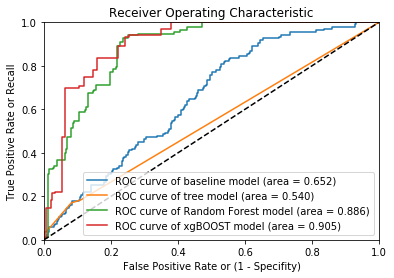

In [0]:
# Malawi FCS 

# Baseline 
y_prob,y_test  = LRCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   40.1s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.1s finished


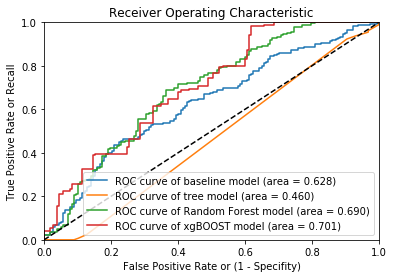

In [0]:
# Malawi rCSI 
plt.close()


# Baseline 
y_prob,y_test  = LRCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   30.7s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.9s finished


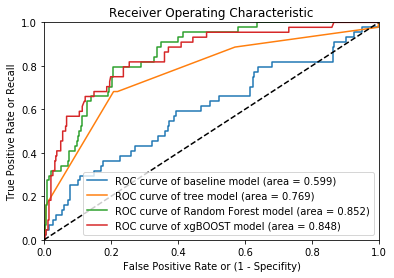

In [0]:
# Tanzania FCS 

# Baseline 
y_prob,y_test  = LRCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.8s finished


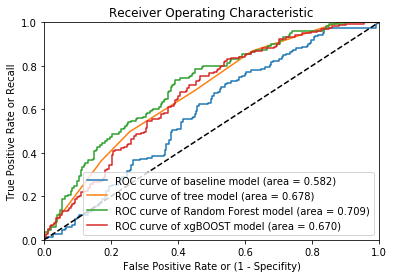

In [0]:
# Tanzania rCSI 

# Baseline 
y_prob,y_test  = LRCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   16.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.1s finished


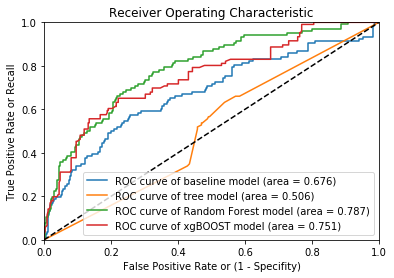

In [0]:
# Uganda FCS 

# Baseline 
y_prob,y_test  = LRCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


## Downsample / oversample 

Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Resampling
A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.



### Oversampling

#### Oversample - binary

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   52.1s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   16.9s finished


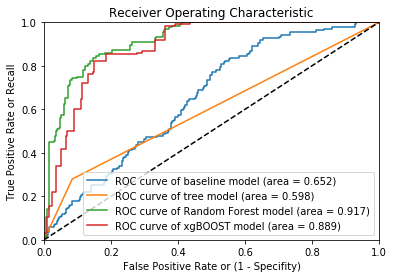

In [0]:
# Oversample MW
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([mw_clust_X_train, mw_clust_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(FCS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

# Malawi FCS 

# Baseline 
y_prob,y_test  = LRCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   50.5s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   16.7s finished


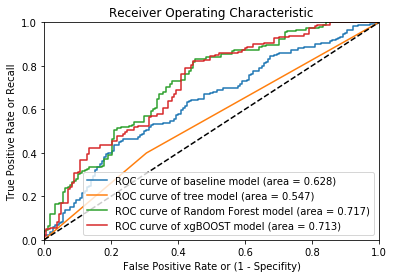

In [0]:
# MW oversample rCSI

from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([mw_clust_X_train, mw_clust_y_train['rCSI_category']], axis=1)


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category==1]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

rCSI_upsampled["rCSI_category"].value_counts()

# Malawi rCSI 

# Baseline 
y_prob,y_test  = LRCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   41.7s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.0s finished


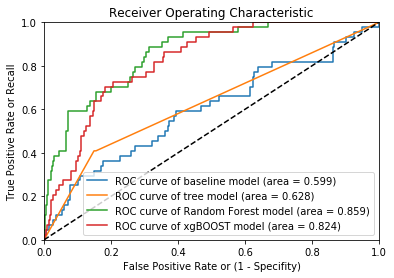

In [0]:
# Oversample TZ FCS

from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([tz_clust_X_train, tz_clust_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results
# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

# Tanzania FCS 

# Baseline 
y_prob,y_test  = LRCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   38.7s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   16.1s finished


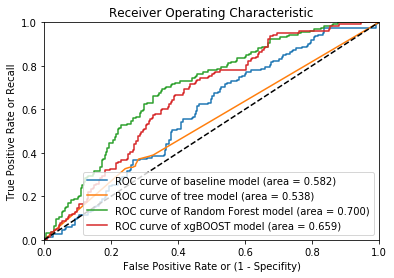

In [0]:

# TZ RCSI

from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([tz_clust_X_train, tz_clust_y_train['rCSI_category']], axis=1)


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(rCSI_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

# Tanzania rCSI 

# Baseline 
y_prob,y_test  = LRCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.6s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.8s finished


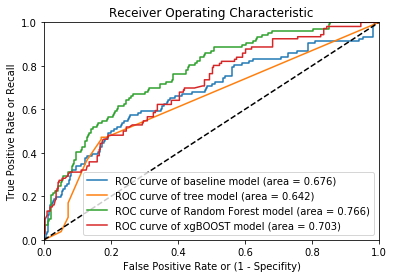

In [0]:


# UG FCS
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ug_clust_X_train, ug_clust_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results
# Uganda FCS 
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

# Baseline 
y_prob,y_test  = LRCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

#### oversample - Three class test

##### all the oversampling

In [0]:
# Oversample MW
from sklearn.utils import resample

# concatenate our training data back together
mw11_fcs_df = pd.concat([mw_clust_X_train_11, mw_clust_y_train_11['FCS_category']], axis=1)

mw11_fcs_not_crisis = mw11_fcs_df[mw11_fcs_df.FCS_category==0]
mw11_fcs_crisis = mw11_fcs_df[mw11_fcs_df.FCS_category==1]

# separate minority and majority classes

# upsample minority
mw11_fcs_crisis_upsampled = resample(mw11_fcs_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(mw11_fcs_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
mw11_fcs_upsampled = pd.concat([mw11_fcs_not_crisis, mw11_fcs_crisis_upsampled])

mw11_fcs_upsampled_upsampled_y_train = mw11_fcs_upsampled["FCS_category"]

mw11_fcs_upsampled_X_train = mw11_fcs_upsampled.drop("FCS_category",axis=1)

 
from sklearn.utils import resample

# concatenate our training data back together
mw13_fcs_df = pd.concat([mw_clust_X_train_13, mw_clust_y_train_13['FCS_category']], axis=1)

mw13_fcs_not_crisis = mw13_fcs_df[mw13_fcs_df.FCS_category!=2]
mw13_fcs_crisis = mw13_fcs_df[mw13_fcs_df.FCS_category==2]

# separate minority and majority classes

# upsample minority
mw13_fcs_crisis_upsampled = resample(mw13_fcs_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(mw13_fcs_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
mw13_fcs_upsampled = pd.concat([mw13_fcs_not_crisis, mw13_fcs_crisis_upsampled])

mw13_fcs_upsampled_upsampled_y_train = mw13_fcs_upsampled["FCS_category"]

mw13_fcs_upsampled_X_train = mw13_fcs_upsampled.drop("FCS_category",axis=1)

from sklearn.utils import resample

# concatenate our training data back together
mw16_fcs_df = pd.concat([mw_clust_X_train_16, mw_clust_y_train_16['FCS_category']], axis=1)

mw16_fcs_not_crisis = mw16_fcs_df[mw16_fcs_df.FCS_category!=2]
mw16_fcs_crisis = mw16_fcs_df[mw16_fcs_df.FCS_category==2]

# separate minority and majority classes

# upsample minority
mw16_fcs_crisis_upsampled = resample(mw16_fcs_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(mw16_fcs_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
mw16_fcs_upsampled = pd.concat([mw16_fcs_not_crisis, mw16_fcs_crisis_upsampled])

mw16_fcs_upsampled_upsampled_y_train = mw16_fcs_upsampled["FCS_category"]

mw16_fcs_upsampled_X_train = mw16_fcs_upsampled.drop("FCS_category",axis=1)


In [0]:
# Oversample MW
from sklearn.utils import resample

# concatenate our training data back together
mw11_rCSI_df = pd.concat([mw_clust_X_train_11, mw_clust_y_train_11['rCSI_category']], axis=1)

mw11_rCSI_not_crisis = mw11_rCSI_df[mw11_rCSI_df.rCSI_category!=2]
mw11_rCSI_crisis = mw11_rCSI_df[mw11_rCSI_df.rCSI_category==2]

# separate minority and majority classes

# upsample minority
mw11_rCSI_crisis_upsampled = resample(mw11_rCSI_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(mw11_rCSI_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
mw11_rCSI_upsampled = pd.concat([mw11_rCSI_not_crisis, mw11_rCSI_crisis_upsampled])

mw11_rCSI_upsampled_upsampled_y_train = mw11_rCSI_upsampled["rCSI_category"]

mw11_rCSI_upsampled_X_train = mw11_rCSI_upsampled.drop("rCSI_category",axis=1)

 
from sklearn.utils import resample

# concatenate our training data back together
mw13_rCSI_df = pd.concat([mw_clust_X_train_13, mw_clust_y_train_13['rCSI_category']], axis=1)

mw13_rCSI_not_crisis = mw13_rCSI_df[mw13_rCSI_df.rCSI_category!=2]
mw13_rCSI_crisis = mw13_rCSI_df[mw13_rCSI_df.rCSI_category==2]

# separate minority and majority classes

# upsample minority
mw13_rCSI_crisis_upsampled = resample(mw13_rCSI_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(mw13_rCSI_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
mw13_rCSI_upsampled = pd.concat([mw13_rCSI_not_crisis, mw13_rCSI_crisis_upsampled])

mw13_rCSI_upsampled_upsampled_y_train = mw13_rCSI_upsampled["rCSI_category"]

mw13_rCSI_upsampled_X_train = mw13_rCSI_upsampled.drop("rCSI_category",axis=1)

from sklearn.utils import resample

# concatenate our training data back together
mw16_rCSI_df = pd.concat([mw_clust_X_train_16, mw_clust_y_train_16['rCSI_category']], axis=1)

mw16_rCSI_not_crisis = mw16_rCSI_df[mw16_rCSI_df.rCSI_category!=2]
mw16_rCSI_crisis = mw16_rCSI_df[mw16_rCSI_df.rCSI_category==2]

# separate minority and majority classes

# upsample minority
mw16_rCSI_crisis_upsampled = resample(mw16_rCSI_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(mw16_rCSI_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
mw16_rCSI_upsampled = pd.concat([mw16_rCSI_not_crisis, mw16_rCSI_crisis_upsampled])

mw16_rCSI_upsampled_upsampled_y_train = mw16_rCSI_upsampled["rCSI_category"]

mw16_rCSI_upsampled_X_train = mw16_rCSI_upsampled.drop("rCSI_category",axis=1)



 

In [0]:
# Oversample tz
from sklearn.utils import resample

# concatenate our training data back together
tz10_fcs_df = pd.concat([tz_clust_X_train_10, tz_clust_y_train_10['FCS_category']], axis=1)

tz10_fcs_not_crisis = tz10_fcs_df[tz10_fcs_df.FCS_category!=2]
tz10_fcs_crisis = tz10_fcs_df[tz10_fcs_df.FCS_category==2]

# separate minority and majority classes

# upsample minority
tz10_fcs_crisis_upsampled = resample(tz10_fcs_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(tz10_fcs_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
tz10_fcs_upsampled = pd.concat([tz10_fcs_not_crisis, tz10_fcs_crisis_upsampled])

tz10_fcs_upsampled_upsampled_y_train = tz10_fcs_upsampled["FCS_category"]

tz10_fcs_upsampled_X_train = tz10_fcs_upsampled.drop("FCS_category",axis=1)

 
from sklearn.utils import resample

# concatenate our training data back together
tz12_fcs_df = pd.concat([tz_clust_X_train_12, tz_clust_y_train_12['FCS_category']], axis=1)

tz12_fcs_not_crisis = tz12_fcs_df[tz12_fcs_df.FCS_category!=2]
tz12_fcs_crisis = tz12_fcs_df[tz12_fcs_df.FCS_category==2]

# separate minority and majority classes

# upsample minority
tz12_fcs_crisis_upsampled = resample(tz12_fcs_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(tz12_fcs_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
tz12_fcs_upsampled = pd.concat([tz12_fcs_not_crisis, tz12_fcs_crisis_upsampled])

tz12_fcs_upsampled_upsampled_y_train = tz12_fcs_upsampled["FCS_category"]

tz12_fcs_upsampled_X_train = tz12_fcs_upsampled.drop("FCS_category",axis=1)

from sklearn.utils import resample

# concatenate our training data back together
tz15_fcs_df = pd.concat([tz_clust_X_train_15, tz_clust_y_train_15['FCS_category']], axis=1)

tz15_fcs_not_crisis = tz15_fcs_df[tz15_fcs_df.FCS_category!=2]
tz15_fcs_crisis = tz15_fcs_df[tz15_fcs_df.FCS_category==2]

# separate minority and majority classes

# upsample minority
tz15_fcs_crisis_upsampled = resample(tz15_fcs_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(tz15_fcs_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
tz15_fcs_upsampled = pd.concat([tz15_fcs_not_crisis, tz15_fcs_crisis_upsampled])

tz15_fcs_upsampled_upsampled_y_train = tz15_fcs_upsampled["FCS_category"]

tz15_fcs_upsampled_X_train = tz15_fcs_upsampled.drop("FCS_category",axis=1)


In [0]:
# Oversample tz
from sklearn.utils import resample

# concatenate our training data back together
tz10_rCSI_df = pd.concat([tz_clust_X_train_10, tz_clust_y_train_10['rCSI_category']], axis=1)

tz10_rCSI_not_crisis = tz10_rCSI_df[tz10_rCSI_df.rCSI_category!=2]
tz10_rCSI_crisis = tz10_rCSI_df[tz10_rCSI_df.rCSI_category==2]

# separate minority and majority classes

# upsample minority
tz10_rCSI_crisis_upsampled = resample(tz10_rCSI_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(tz10_rCSI_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
tz10_rCSI_upsampled = pd.concat([tz10_rCSI_not_crisis, tz10_rCSI_crisis_upsampled])

tz10_rCSI_upsampled_upsampled_y_train = tz10_rCSI_upsampled["rCSI_category"]

tz10_rCSI_upsampled_X_train = tz10_rCSI_upsampled.drop("rCSI_category",axis=1)

 
from sklearn.utils import resample

# concatenate our training data back together
tz12_rCSI_df = pd.concat([tz_clust_X_train_12, tz_clust_y_train_12['rCSI_category']], axis=1)

tz12_rCSI_not_crisis = tz12_rCSI_df[tz12_rCSI_df.rCSI_category!=2]
tz12_rCSI_crisis = tz12_rCSI_df[tz12_rCSI_df.rCSI_category==2]

# separate minority and majority classes

# upsample minority
tz12_rCSI_crisis_upsampled = resample(tz12_rCSI_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(tz12_rCSI_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
tz12_rCSI_upsampled = pd.concat([tz12_rCSI_not_crisis, tz12_rCSI_crisis_upsampled])

tz12_rCSI_upsampled_upsampled_y_train = tz12_rCSI_upsampled["rCSI_category"]

tz12_rCSI_upsampled_X_train = tz12_rCSI_upsampled.drop("rCSI_category",axis=1)

from sklearn.utils import resample

# concatenate our training data back together
tz15_rCSI_df = pd.concat([tz_clust_X_train_15, tz_clust_y_train_15['rCSI_category']], axis=1)

tz15_rCSI_not_crisis = tz15_rCSI_df[tz15_rCSI_df.rCSI_category!=2]
tz15_rCSI_crisis = tz15_rCSI_df[tz15_rCSI_df.rCSI_category==2]

# separate minority and majority classes

# upsample minority
tz15_rCSI_crisis_upsampled = resample(tz15_rCSI_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(tz15_rCSI_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
tz15_rCSI_upsampled = pd.concat([tz15_rCSI_not_crisis, tz15_rCSI_crisis_upsampled])

tz15_rCSI_upsampled_upsampled_y_train = tz15_rCSI_upsampled["rCSI_category"]

tz15_rCSI_upsampled_X_train = tz15_rCSI_upsampled.drop("rCSI_category",axis=1)


In [0]:
# Oversample ug
from sklearn.utils import resample

# concatenate our training data back together
ug10_fcs_df = pd.concat([ug_clust_X_train_10, ug_clust_y_train_10['FCS_category']], axis=1)

ug10_fcs_not_crisis = ug10_fcs_df[ug10_fcs_df.FCS_category!=2]
ug10_fcs_crisis = ug10_fcs_df[ug10_fcs_df.FCS_category==2]

# separate minority and majority classes

# upsample minority
ug10_fcs_crisis_upsampled = resample(ug10_fcs_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(ug10_fcs_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
ug10_fcs_upsampled = pd.concat([ug10_fcs_not_crisis, ug10_fcs_crisis_upsampled])

ug10_fcs_upsampled_upsampled_y_train = ug10_fcs_upsampled["FCS_category"]

ug10_fcs_upsampled_X_train = ug10_fcs_upsampled.drop("FCS_category",axis=1)

 
from sklearn.utils import resample

# concatenate our training data back together
ug12_fcs_df = pd.concat([ug_clust_X_train_12, ug_clust_y_train_12['FCS_category']], axis=1)

ug12_fcs_not_crisis = ug12_fcs_df[ug12_fcs_df.FCS_category!=2]
ug12_fcs_crisis = ug12_fcs_df[ug12_fcs_df.FCS_category==2]

# separate minority and majority classes

# upsample minority
ug12_fcs_crisis_upsampled = resample(ug12_fcs_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(ug12_fcs_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
ug12_fcs_upsampled = pd.concat([ug12_fcs_not_crisis, ug12_fcs_crisis_upsampled])

ug12_fcs_upsampled_upsampled_y_train = ug12_fcs_upsampled["FCS_category"]

ug12_fcs_upsampled_X_train = ug12_fcs_upsampled.drop("FCS_category",axis=1)

from sklearn.utils import resample

# concatenate our training data back together
ug11_fcs_df = pd.concat([ug_clust_X_train_11, ug_clust_y_train_11['FCS_category']], axis=1)

ug11_fcs_not_crisis = ug11_fcs_df[ug11_fcs_df.FCS_category!=2]
ug11_fcs_crisis = ug11_fcs_df[ug11_fcs_df.FCS_category==2]

# separate minority and majority classes

# upsample minority
ug11_fcs_crisis_upsampled = resample(ug11_fcs_not_crisis,replace=True, # sample with replacement
                                 n_samples=len(ug11_fcs_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
ug11_fcs_upsampled = pd.concat([ug11_fcs_not_crisis, ug11_fcs_crisis_upsampled])

ug11_fcs_upsampled_upsampled_y_train = ug11_fcs_upsampled["FCS_category"]

ug11_fcs_upsampled_X_train = ug11_fcs_upsampled.drop("FCS_category",axis=1)


##### Over-sampling results (cross-validated）

In [149]:
print ("Malawi tree oversampling Results")



# mw11
y_pred,y_test  = TreeCLF (mw11_fcs_upsampled_X_train,mw_clust_y_train_11['FCS_category'], mw_clust_X_test_11,mw_clust_y_test_11['FCS_category'] )
precision_mw11_fcs,recall_mw11_fcs,fscore_mw11_fcs,support_mw11_fcs,accuracy_mw11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (mw11_fcs_upsampled_X_train,mw_clust_y_train_11['rCSI_category'], mw_clust_X_test_11,mw_clust_y_test_11['rCSI_category'] )
precision_mw11_rCSI,recall_mw11_rCSI,fscore_mw11_rCSI,support_mw11_rCSI,accuracy_mw11_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# mw13

y_pred,y_test  = TreeCLF (mw13_fcs_upsampled_X_train,mw_clust_y_train_13['FCS_category'], mw_clust_X_test_13,mw_clust_y_test_13['FCS_category'] )
precision_mw13_fcs,recall_mw13_fcs,fscore_mw13_fcs,support_mw13_fcs,accuracy_mw13_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (mw13_fcs_upsampled_X_train,mw_clust_y_train_13['rCSI_category'], mw_clust_X_test_13,mw_clust_y_test_13['rCSI_category'] )
precision_mw13_rCSI,recall_mw13_rCSI,fscore_mw13_rCSI,support_mw13_rCSI,accuracy_mw13_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# mw16


y_pred,y_test  = TreeCLF (mw16_fcs_upsampled_X_train,mw_clust_y_train_16['FCS_category'], mw_clust_X_test_16,mw_clust_y_test_16['FCS_category'] )
precision_mw16_fcs,recall_mw16_fcs,fscore_mw16_fcs,support_mw16_fcs,accuracy_mw16_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (mw16_fcs_upsampled_X_train,mw_clust_y_train_16['rCSI_category'], mw_clust_X_test_16,mw_clust_y_test_16['rCSI_category'] )
precision_mw16_rCSI,recall_mw16_rCSI,fscore_mw16_rCSI,support_mw16_rCSI,accuracy_mw16_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

print ("Tanzania tree oversampling Results")


# tz 10
y_pred,y_test  = TreeCLF (tz10_fcs_upsampled_X_train,tz_clust_y_train_10['FCS_category'], tz_clust_X_test_10,tz_clust_y_test_10['FCS_category'] )
precision_tz10_fcs,recall_tz10_fcs,fscore_tz10_fcs,support_tz10_fcs,accuracy_tz10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (tz10_fcs_upsampled_X_train,tz_clust_y_train_10['rCSI_category'], tz_clust_X_test_10,tz_clust_y_test_10['rCSI_category'] )
precision_tz10_rCSI,recall_tz10_rCSI,fscore_tz10_rCSI,support_tz10_rCSI,accuracy_tz10_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# tz 12

y_pred,y_test  = TreeCLF (tz12_fcs_upsampled_X_train,tz_clust_y_train_12['FCS_category'], tz_clust_X_test_12,tz_clust_y_test_12['FCS_category'] )
precision_tz12_fcs,recall_tz12_fcs,fscore_tz12_fcs,support_tz12_fcs,accuracy_tz12_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (tz12_fcs_upsampled_X_train,tz_clust_y_train_12['rCSI_category'], tz_clust_X_test_12,tz_clust_y_test_12['rCSI_category'] )
precision_tz12_rCSI,recall_tz12_rCSI,fscore_tz12_rCSI,support_tz12_rCSI,accuracy_tz12_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# tz 15
y_pred,y_test  = TreeCLF (tz15_fcs_upsampled_X_train,tz_clust_y_train_15['FCS_category'], tz_clust_X_test_15,tz_clust_y_test_15['FCS_category'] )
precision_tz15_fcs,recall_tz15_fcs,fscore_tz15_fcs,support_tz15_fcs,accuracy_tz15_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = TreeCLF (tz15_fcs_upsampled_X_train,tz_clust_y_train_15['rCSI_category'], tz_clust_X_test_15,tz_clust_y_test_15['rCSI_category'] )
precision_tz15_rCSI,recall_tz15_rCSI,fscore_tz15_rCSI,support_tz15_rCSI,accuracy_tz15_rCSI = pre_rec_f1_support_minority(y_pred,y_test)



print ("Uganda tree oversampling Results")

#ug 10
y_pred,y_test  = TreeCLF (ug10_fcs_upsampled_X_train,ug_clust_y_train_10['FCS_category'], ug_clust_X_test_10,ug_clust_y_test_10['FCS_category'] )
precision_ug10_fcs,recall_ug10_fcs,fscore_ug10_fcs,support_ug10_fcs,accuracy_ug10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 11
y_pred,y_test  = TreeCLF (ug11_fcs_upsampled_X_train,ug_clust_y_train_11['FCS_category'], ug_clust_X_test_11,ug_clust_y_test_11['FCS_category'] )
precision_ug11_fcs,recall_ug11_fcs,fscore_ug11_fcs,support_ug11_fcs,accuracy_ug11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 12
y_pred,y_test  = TreeCLF (ug12_fcs_upsampled_X_train,ug_clust_y_train_12['FCS_category'], ug_clust_X_test_12,ug_clust_y_test_12['FCS_category'] )
precision_ug12_fcs,recall_ug12_fcs,fscore_ug12_fcs,support_ug12_fcs,accuracy_ug12_fcs = pre_rec_f1_support_minority(y_pred,y_test)


# create averages 

# FCS
mw_fcs_precision = sum([precision_mw11_fcs,precision_mw13_fcs,precision_mw16_fcs])/3

mw_fcs_recall = sum([recall_mw11_fcs,recall_mw13_fcs,recall_mw16_fcs])/3

mw_fcs_fscore = sum([fscore_mw11_fcs,fscore_mw13_fcs,fscore_mw16_fcs])/3

mw_fcs_support = sum([support_mw11_fcs,support_mw13_fcs,support_mw16_fcs])/3

mw_fcs_accuracy = sum([accuracy_mw11_fcs,accuracy_mw13_fcs,accuracy_mw16_fcs])/3



tz_fcs_precision = sum([precision_tz10_fcs,precision_tz12_fcs,precision_tz15_fcs])/3

tz_fcs_recall = sum([recall_tz10_fcs,recall_tz12_fcs,recall_tz15_fcs])/3

tz_fcs_fscore = sum([fscore_tz10_fcs,fscore_tz12_fcs,fscore_tz15_fcs])/3

tz_fcs_support = sum([support_tz10_fcs,support_tz12_fcs,support_tz15_fcs])/3

tz_fcs_accuracy = sum([accuracy_tz10_fcs,accuracy_tz12_fcs,accuracy_tz15_fcs])/3


ug_fcs_precision = sum([precision_ug10_fcs,precision_ug12_fcs,precision_ug11_fcs])/3

ug_fcs_recall = sum([recall_ug10_fcs,recall_ug12_fcs,recall_ug11_fcs])/3

ug_fcs_fscore = sum([fscore_ug10_fcs,fscore_ug12_fcs,fscore_ug11_fcs])/3

ug_fcs_support = sum([support_ug10_fcs,support_ug12_fcs,support_ug11_fcs])/3

ug_fcs_accuracy = sum([accuracy_ug10_fcs,accuracy_ug12_fcs,accuracy_ug11_fcs])/3

# rCSI 

mw_rCSI_precision = sum([precision_mw11_rCSI,precision_mw13_rCSI,precision_mw16_rCSI])/3

mw_rCSI_recall = sum([recall_mw11_rCSI,recall_mw13_rCSI,recall_mw16_rCSI])/3

mw_rCSI_fscore = sum([fscore_mw11_rCSI,fscore_mw13_rCSI,fscore_mw16_rCSI])/3

mw_rCSI_support = sum([support_mw11_rCSI,support_mw13_rCSI,support_mw16_rCSI])/3

mw_rCSI_accuracy = sum([accuracy_mw11_rCSI,accuracy_mw13_rCSI,accuracy_mw16_rCSI])/3



tz_rCSI_precision = sum([precision_tz10_rCSI,precision_tz12_rCSI,precision_tz15_rCSI])/3

tz_rCSI_recall = sum([recall_tz10_rCSI,recall_tz12_rCSI,recall_tz15_rCSI])/3

tz_rCSI_fscore = sum([fscore_tz10_rCSI,fscore_tz12_rCSI,fscore_tz15_rCSI])/3

tz_rCSI_support = sum([support_tz10_rCSI,support_tz12_rCSI,support_tz15_rCSI])/3

tz_rCSI_accuracy = sum([accuracy_tz10_rCSI,accuracy_tz12_rCSI,accuracy_tz15_rCSI])/3


data = [['mw_FCS',mw_fcs_precision,mw_fcs_recall,mw_fcs_fscore,mw_fcs_support,mw_fcs_accuracy], ['mw_rCSI',mw_rCSI_precision,mw_rCSI_recall,mw_rCSI_fscore,mw_rCSI_support,mw_rCSI_accuracy], ['tz_FCS',tz_fcs_precision,tz_fcs_recall,tz_fcs_fscore,tz_fcs_support,tz_fcs_accuracy], ['tz_rCSI',tz_rCSI_precision,tz_rCSI_recall,tz_rCSI_fscore,tz_rCSI_support,tz_rCSI_accuracy], ['ug_FCS',ug_fcs_precision,ug_fcs_recall,ug_fcs_fscore,ug_fcs_support,ug_fcs_accuracy] ] 

oversample_tree_df = pd.DataFrame(data, columns = ['model', 'precision','recall','fscore','support','accuracy']) 
  
# print dataframe. 
from google.colab import files

oversample_tree_df.to_csv('oversample_tree_df.csv')



Malawi tree oversampling Results
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.5s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.5s finished


Tanzania tree oversampling Results
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.5s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.5s finished


Uganda tree oversampling Results
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished


In [0]:
print ("Malawi RFCoversampling Results")



# mw11
y_pred,y_test  = rfCLF(mw11_fcs_upsampled_X_train,mw_clust_y_train_11['FCS_category'], mw_clust_X_test_11,mw_clust_y_test_11['FCS_category'] )
precision_mw11_fcs,recall_mw11_fcs,fscore_mw11_fcs,support_mw11_fcs,accuracy_mw11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(mw11_fcs_upsampled_X_train,mw_clust_y_train_11['rCSI_category'], mw_clust_X_test_11,mw_clust_y_test_11['rCSI_category'] )
precision_mw11_rCSI,recall_mw11_rCSI,fscore_mw11_rCSI,support_mw11_rCSI,accuracy_mw11_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# mw13

y_pred,y_test  = rfCLF(mw13_fcs_upsampled_X_train,mw_clust_y_train_13['FCS_category'], mw_clust_X_test_13,mw_clust_y_test_13['FCS_category'] )
precision_mw13_fcs,recall_mw13_fcs,fscore_mw13_fcs,support_mw13_fcs,accuracy_mw13_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(mw13_fcs_upsampled_X_train,mw_clust_y_train_13['rCSI_category'], mw_clust_X_test_13,mw_clust_y_test_13['rCSI_category'] )
precision_mw13_rCSI,recall_mw13_rCSI,fscore_mw13_rCSI,support_mw13_rCSI,accuracy_mw13_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# mw16


y_pred,y_test  = rfCLF(mw16_fcs_upsampled_X_train,mw_clust_y_train_16['FCS_category'], mw_clust_X_test_16,mw_clust_y_test_16['FCS_category'] )
precision_mw16_fcs,recall_mw16_fcs,fscore_mw16_fcs,support_mw16_fcs,accuracy_mw16_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(mw16_fcs_upsampled_X_train,mw_clust_y_train_16['rCSI_category'], mw_clust_X_test_16,mw_clust_y_test_16['rCSI_category'] )
precision_mw16_rCSI,recall_mw16_rCSI,fscore_mw16_rCSI,support_mw16_rCSI,accuracy_mw16_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

print ("Tanzania RFCoversampling Results")


# tz 10
y_pred,y_test  = rfCLF(tz10_fcs_upsampled_X_train,tz_clust_y_train_10['FCS_category'], tz_clust_X_test_10,tz_clust_y_test_10['FCS_category'] )
precision_tz10_fcs,recall_tz10_fcs,fscore_tz10_fcs,support_tz10_fcs,accuracy_tz10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(tz10_fcs_upsampled_X_train,tz_clust_y_train_10['rCSI_category'], tz_clust_X_test_10,tz_clust_y_test_10['rCSI_category'] )
precision_tz10_rCSI,recall_tz10_rCSI,fscore_tz10_rCSI,support_tz10_rCSI,accuracy_tz10_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# tz 12

y_pred,y_test  = rfCLF(tz12_fcs_upsampled_X_train,tz_clust_y_train_12['FCS_category'], tz_clust_X_test_12,tz_clust_y_test_12['FCS_category'] )
precision_tz12_fcs,recall_tz12_fcs,fscore_tz12_fcs,support_tz12_fcs,accuracy_tz12_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(tz12_fcs_upsampled_X_train,tz_clust_y_train_12['rCSI_category'], tz_clust_X_test_12,tz_clust_y_test_12['rCSI_category'] )
precision_tz12_rCSI,recall_tz12_rCSI,fscore_tz12_rCSI,support_tz12_rCSI,accuracy_tz12_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# tz 15
y_pred,y_test  = rfCLF(tz15_fcs_upsampled_X_train,tz_clust_y_train_15['FCS_category'], tz_clust_X_test_15,tz_clust_y_test_15['FCS_category'] )
precision_tz15_fcs,recall_tz15_fcs,fscore_tz15_fcs,support_tz15_fcs,accuracy_tz15_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = rfCLF(tz15_fcs_upsampled_X_train,tz_clust_y_train_15['rCSI_category'], tz_clust_X_test_15,tz_clust_y_test_15['rCSI_category'] )
precision_tz15_rCSI,recall_tz15_rCSI,fscore_tz15_rCSI,support_tz15_rCSI,accuracy_tz15_rCSI = pre_rec_f1_support_minority(y_pred,y_test)



print ("Uganda RFCoversampling Results")

#ug 10
y_pred,y_test  = rfCLF(ug10_fcs_upsampled_X_train,ug_clust_y_train_10['FCS_category'], ug_clust_X_test_10,ug_clust_y_test_10['FCS_category'] )
precision_ug10_fcs,recall_ug10_fcs,fscore_ug10_fcs,support_ug10_fcs,accuracy_ug10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 11
y_pred,y_test  = rfCLF(ug11_fcs_upsampled_X_train,ug_clust_y_train_11['FCS_category'], ug_clust_X_test_11,ug_clust_y_test_11['FCS_category'] )
precision_ug11_fcs,recall_ug11_fcs,fscore_ug11_fcs,support_ug11_fcs,accuracy_ug11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 12
y_pred,y_test  = rfCLF(ug12_fcs_upsampled_X_train,ug_clust_y_train_12['FCS_category'], ug_clust_X_test_12,ug_clust_y_test_12['FCS_category'] )
precision_ug12_fcs,recall_ug12_fcs,fscore_ug12_fcs,support_ug12_fcs,accuracy_ug12_fcs = pre_rec_f1_support_minority(y_pred,y_test)


# create averages 

# FCS
mw_fcs_precision = sum([precision_mw11_fcs,precision_mw13_fcs,precision_mw16_fcs])/3

mw_fcs_recall = sum([recall_mw11_fcs,recall_mw13_fcs,recall_mw16_fcs])/3

mw_fcs_fscore = sum([fscore_mw11_fcs,fscore_mw13_fcs,fscore_mw16_fcs])/3

mw_fcs_support = sum([support_mw11_fcs,support_mw13_fcs,support_mw16_fcs])/3

mw_fcs_accuracy = sum([accuracy_mw11_fcs,accuracy_mw13_fcs,accuracy_mw16_fcs])/3



tz_fcs_precision = sum([precision_tz10_fcs,precision_tz12_fcs,precision_tz15_fcs])/3

tz_fcs_recall = sum([recall_tz10_fcs,recall_tz12_fcs,recall_tz15_fcs])/3

tz_fcs_fscore = sum([fscore_tz10_fcs,fscore_tz12_fcs,fscore_tz15_fcs])/3

tz_fcs_support = sum([support_tz10_fcs,support_tz12_fcs,support_tz15_fcs])/3

tz_fcs_accuracy = sum([accuracy_tz10_fcs,accuracy_tz12_fcs,accuracy_tz15_fcs])/3


ug_fcs_precision = sum([precision_ug10_fcs,precision_ug12_fcs,precision_ug11_fcs])/3

ug_fcs_recall = sum([recall_ug10_fcs,recall_ug12_fcs,recall_ug11_fcs])/3

ug_fcs_fscore = sum([fscore_ug10_fcs,fscore_ug12_fcs,fscore_ug11_fcs])/3

ug_fcs_support = sum([support_ug10_fcs,support_ug12_fcs,support_ug11_fcs])/3

ug_fcs_accuracy = sum([accuracy_ug10_fcs,accuracy_ug12_fcs,accuracy_ug11_fcs])/3

# rCSI 

mw_rCSI_precision = sum([precision_mw11_rCSI,precision_mw13_rCSI,precision_mw16_rCSI])/3

mw_rCSI_recall = sum([recall_mw11_rCSI,recall_mw13_rCSI,recall_mw16_rCSI])/3

mw_rCSI_fscore = sum([fscore_mw11_rCSI,fscore_mw13_rCSI,fscore_mw16_rCSI])/3

mw_rCSI_support = sum([support_mw11_rCSI,support_mw13_rCSI,support_mw16_rCSI])/3

mw_rCSI_accuracy = sum([accuracy_mw11_rCSI,accuracy_mw13_rCSI,accuracy_mw16_rCSI])/3



tz_rCSI_precision = sum([precision_tz10_rCSI,precision_tz12_rCSI,precision_tz15_rCSI])/3

tz_rCSI_recall = sum([recall_tz10_rCSI,recall_tz12_rCSI,recall_tz15_rCSI])/3

tz_rCSI_fscore = sum([fscore_tz10_rCSI,fscore_tz12_rCSI,fscore_tz15_rCSI])/3

tz_rCSI_support = sum([support_tz10_rCSI,support_tz12_rCSI,support_tz15_rCSI])/3

tz_rCSI_accuracy = sum([accuracy_tz10_rCSI,accuracy_tz12_rCSI,accuracy_tz15_rCSI])/3


data = [['mw_FCS',mw_fcs_precision,mw_fcs_recall,mw_fcs_fscore,mw_fcs_support,mw_fcs_accuracy], ['mw_rCSI',mw_rCSI_precision,mw_rCSI_recall,mw_rCSI_fscore,mw_rCSI_support,mw_rCSI_accuracy], ['tz_FCS',tz_fcs_precision,tz_fcs_recall,tz_fcs_fscore,tz_fcs_support,tz_fcs_accuracy], ['tz_rCSI',tz_rCSI_precision,tz_rCSI_recall,tz_rCSI_fscore,tz_rCSI_support,tz_rCSI_accuracy], ['ug_FCS',ug_fcs_precision,ug_fcs_recall,ug_fcs_fscore,ug_fcs_support,ug_fcs_accuracy] ] 

oversample_rfc_df = pd.DataFrame(data, columns = ['model', 'precision','recall','fscore','support','accuracy']) 
  
# print dataframe. 
from google.colab import files

oversample_rfc_df.to_csv('oversample_rfc_df.csv')



Malawi RFCoversampling Results
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.4s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   36.7s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   38.8s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   43.9s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   48.1s finished


Tanzania RFCoversampling Results
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.3s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.1s


In [0]:
print ("Malawi XGB_oversampling Results")



# mw11
y_pred,y_test  = XGBCLF(mw11_fcs_upsampled_X_train,mw_clust_y_train_11['FCS_category'], mw_clust_X_test_11,mw_clust_y_test_11['FCS_category'] )
precision_mw11_fcs,recall_mw11_fcs,fscore_mw11_fcs,support_mw11_fcs,accuracy_mw11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(mw11_fcs_upsampled_X_train,mw_clust_y_train_11['rCSI_category'], mw_clust_X_test_11,mw_clust_y_test_11['rCSI_category'] )
precision_mw11_rCSI,recall_mw11_rCSI,fscore_mw11_rCSI,support_mw11_rCSI,accuracy_mw11_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# mw13

y_pred,y_test  = XGBCLF(mw13_fcs_upsampled_X_train,mw_clust_y_train_13['FCS_category'], mw_clust_X_test_13,mw_clust_y_test_13['FCS_category'] )
precision_mw13_fcs,recall_mw13_fcs,fscore_mw13_fcs,support_mw13_fcs,accuracy_mw13_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(mw13_fcs_upsampled_X_train,mw_clust_y_train_13['rCSI_category'], mw_clust_X_test_13,mw_clust_y_test_13['rCSI_category'] )
precision_mw13_rCSI,recall_mw13_rCSI,fscore_mw13_rCSI,support_mw13_rCSI,accuracy_mw13_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# mw16


y_pred,y_test  = XGBCLF(mw16_fcs_upsampled_X_train,mw_clust_y_train_16['FCS_category'], mw_clust_X_test_16,mw_clust_y_test_16['FCS_category'] )
precision_mw16_fcs,recall_mw16_fcs,fscore_mw16_fcs,support_mw16_fcs,accuracy_mw16_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(mw16_fcs_upsampled_X_train,mw_clust_y_train_16['rCSI_category'], mw_clust_X_test_16,mw_clust_y_test_16['rCSI_category'] )
precision_mw16_rCSI,recall_mw16_rCSI,fscore_mw16_rCSI,support_mw16_rCSI,accuracy_mw16_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

print ("Tanzania XGB_oversampling Results")


# tz 10
y_pred,y_test  = XGBCLF(tz10_fcs_upsampled_X_train,tz_clust_y_train_10['FCS_category'], tz_clust_X_test_10,tz_clust_y_test_10['FCS_category'] )
precision_tz10_fcs,recall_tz10_fcs,fscore_tz10_fcs,support_tz10_fcs,accuracy_tz10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(tz10_fcs_upsampled_X_train,tz_clust_y_train_10['rCSI_category'], tz_clust_X_test_10,tz_clust_y_test_10['rCSI_category'] )
precision_tz10_rCSI,recall_tz10_rCSI,fscore_tz10_rCSI,support_tz10_rCSI,accuracy_tz10_rCSI = pre_rec_f1_support_minority(y_pred,y_test)

# tz 12

y_pred,y_test  = XGBCLF(tz12_fcs_upsampled_X_train,tz_clust_y_train_12['FCS_category'], tz_clust_X_test_12,tz_clust_y_test_12['FCS_category'] )
precision_tz12_fcs,recall_tz12_fcs,fscore_tz12_fcs,support_tz12_fcs,accuracy_tz12_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(tz12_fcs_upsampled_X_train,tz_clust_y_train_12['rCSI_category'], tz_clust_X_test_12,tz_clust_y_test_12['rCSI_category'] )
precision_tz12_rCSI,recall_tz12_rCSI,fscore_tz12_rCSI,support_tz12_rCSI,accuracy_tz12_rCSI = pre_rec_f1_support_minority(y_pred,y_test)


# tz 15
y_pred,y_test  = XGBCLF(tz15_fcs_upsampled_X_train,tz_clust_y_train_15['FCS_category'], tz_clust_X_test_15,tz_clust_y_test_15['FCS_category'] )
precision_tz15_fcs,recall_tz15_fcs,fscore_tz15_fcs,support_tz15_fcs,accuracy_tz15_fcs = pre_rec_f1_support_minority(y_pred,y_test)

y_pred,y_test  = XGBCLF(tz15_fcs_upsampled_X_train,tz_clust_y_train_15['rCSI_category'], tz_clust_X_test_15,tz_clust_y_test_15['rCSI_category'] )
precision_tz15_rCSI,recall_tz15_rCSI,fscore_tz15_rCSI,support_tz15_rCSI,accuracy_tz15_rCSI = pre_rec_f1_support_minority(y_pred,y_test)



print ("Uganda XGB_oversampling Results")

#ug 10
y_pred,y_test  = XGBCLF(ug10_fcs_upsampled_X_train,ug_clust_y_train_10['FCS_category'], ug_clust_X_test_10,ug_clust_y_test_10['FCS_category'] )
precision_ug10_fcs,recall_ug10_fcs,fscore_ug10_fcs,support_ug10_fcs,accuracy_ug10_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 11
y_pred,y_test  = XGBCLF(ug11_fcs_upsampled_X_train,ug_clust_y_train_11['FCS_category'], ug_clust_X_test_11,ug_clust_y_test_11['FCS_category'] )
precision_ug11_fcs,recall_ug11_fcs,fscore_ug11_fcs,support_ug11_fcs,accuracy_ug11_fcs = pre_rec_f1_support_minority(y_pred,y_test)

#ug 12
y_pred,y_test  = XGBCLF(ug12_fcs_upsampled_X_train,ug_clust_y_train_12['FCS_category'], ug_clust_X_test_12,ug_clust_y_test_12['FCS_category'] )
precision_ug12_fcs,recall_ug12_fcs,fscore_ug12_fcs,support_ug12_fcs,accuracy_ug12_fcs = pre_rec_f1_support_minority(y_pred,y_test)


# create averages 

# FCS
mw_fcs_precision = sum([precision_mw11_fcs,precision_mw13_fcs,precision_mw16_fcs])/3

mw_fcs_recall = sum([recall_mw11_fcs,recall_mw13_fcs,recall_mw16_fcs])/3

mw_fcs_fscore = sum([fscore_mw11_fcs,fscore_mw13_fcs,fscore_mw16_fcs])/3

mw_fcs_support = sum([support_mw11_fcs,support_mw13_fcs,support_mw16_fcs])/3

mw_fcs_accuracy = sum([accuracy_mw11_fcs,accuracy_mw13_fcs,accuracy_mw16_fcs])/3



tz_fcs_precision = sum([precision_tz10_fcs,precision_tz12_fcs,precision_tz15_fcs])/3

tz_fcs_recall = sum([recall_tz10_fcs,recall_tz12_fcs,recall_tz15_fcs])/3

tz_fcs_fscore = sum([fscore_tz10_fcs,fscore_tz12_fcs,fscore_tz15_fcs])/3

tz_fcs_support = sum([support_tz10_fcs,support_tz12_fcs,support_tz15_fcs])/3

tz_fcs_accuracy = sum([accuracy_tz10_fcs,accuracy_tz12_fcs,accuracy_tz15_fcs])/3


ug_fcs_precision = sum([precision_ug10_fcs,precision_ug12_fcs,precision_ug11_fcs])/3

ug_fcs_recall = sum([recall_ug10_fcs,recall_ug12_fcs,recall_ug11_fcs])/3

ug_fcs_fscore = sum([fscore_ug10_fcs,fscore_ug12_fcs,fscore_ug11_fcs])/3

ug_fcs_support = sum([support_ug10_fcs,support_ug12_fcs,support_ug11_fcs])/3

ug_fcs_accuracy = sum([accuracy_ug10_fcs,accuracy_ug12_fcs,accuracy_ug11_fcs])/3

# rCSI 

mw_rCSI_precision = sum([precision_mw11_rCSI,precision_mw13_rCSI,precision_mw16_rCSI])/3

mw_rCSI_recall = sum([recall_mw11_rCSI,recall_mw13_rCSI,recall_mw16_rCSI])/3

mw_rCSI_fscore = sum([fscore_mw11_rCSI,fscore_mw13_rCSI,fscore_mw16_rCSI])/3

mw_rCSI_support = sum([support_mw11_rCSI,support_mw13_rCSI,support_mw16_rCSI])/3

mw_rCSI_accuracy = sum([accuracy_mw11_rCSI,accuracy_mw13_rCSI,accuracy_mw16_rCSI])/3



tz_rCSI_precision = sum([precision_tz10_rCSI,precision_tz12_rCSI,precision_tz15_rCSI])/3

tz_rCSI_recall = sum([recall_tz10_rCSI,recall_tz12_rCSI,recall_tz15_rCSI])/3

tz_rCSI_fscore = sum([fscore_tz10_rCSI,fscore_tz12_rCSI,fscore_tz15_rCSI])/3

tz_rCSI_support = sum([support_tz10_rCSI,support_tz12_rCSI,support_tz15_rCSI])/3

tz_rCSI_accuracy = sum([accuracy_tz10_rCSI,accuracy_tz12_rCSI,accuracy_tz15_rCSI])/3


data = [['mw_FCS',mw_fcs_precision,mw_fcs_recall,mw_fcs_fscore,mw_fcs_support,mw_fcs_accuracy], ['mw_rCSI',mw_rCSI_precision,mw_rCSI_recall,mw_rCSI_fscore,mw_rCSI_support,mw_rCSI_accuracy], ['tz_FCS',tz_fcs_precision,tz_fcs_recall,tz_fcs_fscore,tz_fcs_support,tz_fcs_accuracy], ['tz_rCSI',tz_rCSI_precision,tz_rCSI_recall,tz_rCSI_fscore,tz_rCSI_support,tz_rCSI_accuracy], ['ug_FCS',ug_fcs_precision,ug_fcs_recall,ug_fcs_fscore,ug_fcs_support,ug_fcs_accuracy] ] 

oversample_XGB_df = pd.DataFrame(data, columns = ['model', 'precision','recall','fscore','support','accuracy']) 
  
# print dataframe. 
from google.colab import files

oversample_XGB_df.to_csv('oversample_XGB_df.csv')



### SMOTE Tomek - Three class

In [0]:
import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)

mw_smote_X_train, mw_smote_FCS_y_train = smt.fit_resample(mw_clust_X_train, mw_clust_y_train['FCS_category'])


print ("Tree model results with oversampling") 
y_pred,y_test  = TreeCLF (mw_smote_X_train,mw_smote_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred)) 


print ("RFC model results with oversampling") 

y_pred,y_test  = rfCLF (mw_smote_X_train,mw_smote_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  = XGBCLF (mw_smote_X_train,mw_smote_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

Tree model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.44      0.13      0.20       309
           1       0.24      0.61      0.34       136

    accuracy                           0.28       445
   macro avg       0.34      0.37      0.27       445
weighted avg       0.38      0.28      0.25       445

RFC model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.9min finished


              precision    recall  f1-score   support

           0       0.71      0.96      0.82       309
           1       0.58      0.13      0.22       136

    accuracy                           0.71       445
   macro avg       0.65      0.55      0.52       445
weighted avg       0.67      0.71      0.63       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


              precision    recall  f1-score   support

           0       0.72      1.00      0.84       309
           1       1.00      0.12      0.21       136

    accuracy                           0.73       445
   macro avg       0.86      0.56      0.52       445
weighted avg       0.81      0.73      0.65       445



### ADASYN

In [0]:
import imblearn

from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42,n_jobs=5)

 

mw_ada_X_train, mw_ada_FCS_y_train = ada.fit_resample(mw_clust_X_train, mw_clust_y_train['FCS_category'])


print ("Tree model results with oversampling") 
y_pred,y_test  = TreeCLF (mw_ada_X_train,mw_ada_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred)) 


print ("RFC model results with oversampling") 

y_pred,y_test  = rfCLF (mw_ada_X_train,mw_ada_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  = XGBCLF (mw_ada_X_train,mw_ada_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


Tree model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.81      0.94      0.87       309
           1       0.80      0.50      0.62       136

    accuracy                           0.81       445
   macro avg       0.81      0.72      0.74       445
weighted avg       0.81      0.81      0.79       445

RFC model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.3min finished


              precision    recall  f1-score   support

           0       0.71      1.00      0.83       309
           1       1.00      0.06      0.11       136

    accuracy                           0.71       445
   macro avg       0.85      0.53      0.47       445
weighted avg       0.80      0.71      0.61       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


              precision    recall  f1-score   support

           0       0.72      0.99      0.83       309
           1       0.88      0.11      0.20       136

    accuracy                           0.72       445
   macro avg       0.80      0.55      0.51       445
weighted avg       0.77      0.72      0.64       445



In [0]:
import imblearn

from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42,n_jobs=5,sampling_strategy='not minority')

 

mw_ada_X_train, mw_ada_rCSI_y_train = ada.fit_resample(mw_clust_X_train, mw_clust_y_train['rCSI_category'])


print ("Tree model results with oversampling") 
y_pred,y_test  = TreeCLF (mw_ada_X_train,mw_ada_rCSI_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred)) 


print ("RFC model results with oversampling") 

y_pred,y_test  = rfCLF (mw_ada_X_train,mw_ada_rCSI_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  = XGBCLF (mw_ada_X_train,mw_ada_rCSI_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


Tree model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.41      0.75      0.53       157
           1       0.71      0.40      0.51       282
           2       0.00      0.00      0.00         6

    accuracy                           0.52       445
   macro avg       0.37      0.38      0.35       445
weighted avg       0.60      0.52      0.51       445

RFC model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


              precision    recall  f1-score   support

           0       0.40      0.78      0.53       157
           1       0.72      0.35      0.47       282
           2       0.00      0.00      0.00         6

    accuracy                           0.50       445
   macro avg       0.37      0.38      0.33       445
weighted avg       0.60      0.50      0.49       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   35.0s finished


              precision    recall  f1-score   support

           0       0.54      0.58      0.56       157
           1       0.74      0.73      0.74       282
           2       0.00      0.00      0.00         6

    accuracy                           0.67       445
   macro avg       0.43      0.44      0.43       445
weighted avg       0.66      0.67      0.66       445



In [0]:
import imblearn

from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42,n_jobs=5)

 

tz_ada_X_train, tz_ada_FCS_y_train = ada.fit_resample(tz_clust_X_train, tz_clust_y_train['FCS_category'])


print ("Tree model results with oversampling") 
y_pred,y_test  = TreeCLF (tz_ada_X_train,tz_ada_FCS_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred)) 


print ("RFC model results with oversampling") 

y_pred,y_test  = rfCLF (tz_ada_X_train,tz_ada_FCS_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  = XGBCLF (tz_ada_X_train,tz_ada_FCS_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


Tree model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.95      0.61      0.74       342
           1       0.18      0.70      0.29        43
           2       0.00      0.00      0.00         1

    accuracy                           0.61       386
   macro avg       0.38      0.43      0.34       386
weighted avg       0.87      0.61      0.69       386

RFC model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


              precision    recall  f1-score   support

           0       0.94      0.93      0.93       342
           1       0.46      0.49      0.47        43
           2       0.00      0.00      0.00         1

    accuracy                           0.88       386
   macro avg       0.46      0.47      0.47       386
weighted avg       0.88      0.88      0.88       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.5min finished


              precision    recall  f1-score   support

           0       0.95      0.80      0.87       342
           1       0.29      0.65      0.40        43
           2       0.00      0.00      0.00         1

    accuracy                           0.78       386
   macro avg       0.41      0.49      0.42       386
weighted avg       0.87      0.78      0.82       386



In [0]:
import imblearn

from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42,n_jobs=5)

 

tz_ada_X_train, tz_ada_rCSI_y_train = ada.fit_resample(tz_clust_X_train, tz_clust_y_train['rCSI_category'])


print ("Tree model results with oversampling") 
y_pred,y_test  = TreeCLF (tz_ada_X_train,tz_ada_rCSI_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred)) 


print ("RFC model results with oversampling") 

y_pred,y_test  = rfCLF (tz_ada_X_train,tz_ada_rCSI_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  = XGBCLF (tz_ada_X_train,tz_ada_rCSI_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


Tree model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.63      0.70      0.67       227
           1       0.47      0.37      0.41       153
           2       0.00      0.00      0.00         6

    accuracy                           0.56       386
   macro avg       0.37      0.36      0.36       386
weighted avg       0.56      0.56      0.56       386

RFC model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


              precision    recall  f1-score   support

           0       0.68      0.74      0.70       227
           1       0.53      0.48      0.50       153
           2       0.00      0.00      0.00         6

    accuracy                           0.62       386
   macro avg       0.40      0.40      0.40       386
weighted avg       0.61      0.62      0.61       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished


              precision    recall  f1-score   support

           0       0.71      0.60      0.65       227
           1       0.51      0.64      0.56       153
           2       0.00      0.00      0.00         6

    accuracy                           0.61       386
   macro avg       0.41      0.41      0.41       386
weighted avg       0.62      0.61      0.61       386



In [0]:
import imblearn

from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42,n_jobs=5)

 

ug_ada_X_train, ug_ada_FCS_y_train = ada.fit_resample(ug_clust_X_train, ug_clust_y_train['FCS_category'])


print ("Tree model results with oversampling") 
y_pred,y_test  = TreeCLF (ug_ada_X_train,ug_ada_FCS_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred)) 


print ("RFC model results with oversampling") 

y_pred,y_test  = rfCLF (ug_ada_X_train,ug_ada_FCS_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  = XGBCLF (ug_ada_X_train,ug_ada_FCS_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


Tree model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.79      0.60      0.68       334
           1       0.19      0.29      0.23        97
           2       0.09      0.33      0.14         9

    accuracy                           0.53       440
   macro avg       0.35      0.41      0.35       440
weighted avg       0.64      0.53      0.57       440

RFC model results with oversampling
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   33.0s finished


              precision    recall  f1-score   support

           0       0.85      0.90      0.87       334
           1       0.51      0.42      0.46        97
           2       0.33      0.22      0.27         9

    accuracy                           0.78       440
   macro avg       0.56      0.51      0.53       440
weighted avg       0.76      0.78      0.77       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.5s finished


              precision    recall  f1-score   support

           0       0.85      0.77      0.81       334
           1       0.35      0.39      0.37        97
           2       0.14      0.44      0.21         9

    accuracy                           0.68       440
   macro avg       0.45      0.54      0.46       440
weighted avg       0.73      0.68      0.70       440



For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

### Smote - Binary

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   19.3s finished


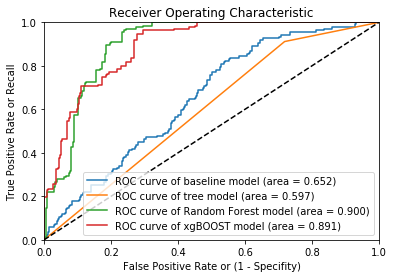

In [0]:
import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)

mw_smote_X_train, mw_smote_FCS_y_train = smt.fit_sample(mw_clust_X_train, mw_clust_y_train['FCS_category'])
 
# Malawi FCS 

# Baseline 
y_prob,y_test  = LRCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (mw_smote_X_train,mw_smote_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (mw_smote_X_train,mw_smote_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (mw_smote_X_train,mw_smote_FCS_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.7s finished


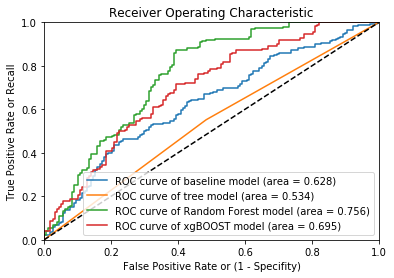

In [0]:
import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)

mw_smote_X_train, mw_smote_rCSI_y_train = smt.fit_sample(mw_clust_X_train, mw_clust_y_train['rCSI_category'])
 
# Malawi rCSI 

# Baseline 
y_prob,y_test  = LRCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (mw_smote_X_train,mw_smote_rCSI_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (mw_smote_X_train,mw_smote_rCSI_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (mw_smote_X_train,mw_smote_rCSI_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   55.2s finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   21.2s finished


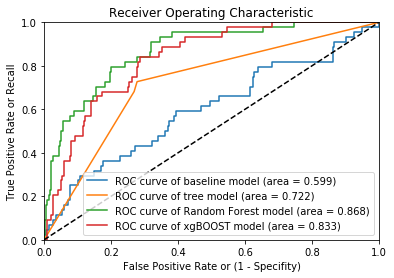

In [0]:
import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)

tz_smote_X_train, tz_smote_FCS_y_train = smt.fit_sample(tz_clust_X_train, tz_clust_y_train['FCS_category'])
 
# Tazania FCS 

# Baseline 
y_prob,y_test  = LRCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of baseline model (area = %0.3f)' % roc_auc)

# Tree
y_prob,y_test  = TreeCLF (tz_smote_X_train,tz_smote_FCS_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of tree model (area = %0.3f)' % roc_auc)

# rfc
y_prob,y_test  = rfCLF (tz_smote_X_train,tz_smote_FCS_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of Random Forest model (area = %0.3f)' % roc_auc)

# XGB
y_prob,y_test  = XGBCLF (tz_smote_X_train,tz_smote_FCS_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve of xgBOOST model (area = %0.3f)' % roc_auc)


# Plot the grid
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()


## Region split results

In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([mw_clust_X_train_region, mw_clust_y_train_region['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(FCS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['FCS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.9s finished


              precision    recall  f1-score   support

           0       0.85      0.89      0.87       749
           1       0.59      0.49      0.53       237
           2       0.00      0.00      0.00         1

    accuracy                           0.79       987
   macro avg       0.48      0.46      0.47       987
weighted avg       0.78      0.79      0.79       987

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.9min finished


              precision    recall  f1-score   support

           0       0.87      0.84      0.85       749
           1       0.53      0.59      0.56       237
           2       0.00      0.00      0.00         1

    accuracy                           0.78       987
   macro avg       0.47      0.48      0.47       987
weighted avg       0.79      0.78      0.78       987



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([mw_clust_X_train_region, mw_clust_y_train_region['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['HDDS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.64      0.97      0.77       194
           1       0.99      0.87      0.93       793

    accuracy                           0.89       987
   macro avg       0.82      0.92      0.85       987
weighted avg       0.92      0.89      0.90       987

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.0s


              precision    recall  f1-score   support

           0       0.66      0.90      0.76       194
           1       0.97      0.89      0.93       793

    accuracy                           0.89       987
   macro avg       0.82      0.89      0.85       987
weighted avg       0.91      0.89      0.90       987



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.7s finished


In [0]:
from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([mw_clust_X_train_region, mw_clust_y_train_region['rCSI_category']], axis=1)


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_clust_X_test_region,mw_clust_y_test_region['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.9s finished


              precision    recall  f1-score   support

           0       0.84      0.91      0.87       740
           1       0.63      0.49      0.55       247

    accuracy                           0.80       987
   macro avg       0.74      0.70      0.71       987
weighted avg       0.79      0.80      0.79       987

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.6min finished


              precision    recall  f1-score   support

           0       0.87      0.81      0.84       740
           1       0.53      0.64      0.58       247

    accuracy                           0.77       987
   macro avg       0.70      0.73      0.71       987
weighted avg       0.79      0.77      0.77       987



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ug_clust_X_train_region, ug_clust_y_train_region['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test_region,ug_clust_y_test_region['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test_region,ug_clust_y_test_region['FCS_category'] )

print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([ug_clust_X_train_region, ug_clust_y_train_region['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_clust_X_test_region,ug_clust_y_test_region['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_clust_X_test_region,ug_clust_y_test_region['HDDS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.2s finished


              precision    recall  f1-score   support

           0       0.79      0.97      0.87       346
           1       0.36      0.09      0.14        89
           2       0.00      0.00      0.00        15

    accuracy                           0.76       450
   macro avg       0.38      0.35      0.34       450
weighted avg       0.68      0.76      0.70       450

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.7s finished


              precision    recall  f1-score   support

           0       0.81      0.88      0.84       346
           1       0.33      0.27      0.30        89
           2       0.00      0.00      0.00        15

    accuracy                           0.73       450
   macro avg       0.38      0.38      0.38       450
weighted avg       0.69      0.73      0.71       450

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.25      0.97      0.39        66
           1       0.97      0.49      0.65       374
           2       0.00      0.00      0.00        10

    accuracy                           0.55       450
   macro avg       0.40      0.49      0.35       450
weighted avg       0.84      0.55      0.60       450

Fitting 3 folds for each of 30 candidates, totalling 90 fits
              precision    recall  f1-score   support

           0       0.19      0.92      0.32        66
           1       0.94      0.33      0.49       374
           2       0.00      0.00      0.00        10

    accuracy                           0.41       450
   macro avg       0.38      0.42      0.27       450
weighted avg       0.81      0.41      0.45       450



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.6s finished


## Random split results 

In [0]:
X_train_ug, X_test_ug, y_train_ug, y_test_ug 



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([X_train_ug, y_train_ug['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, X_test_ug,y_test_ug['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, X_test_ug,y_test_ug['FCS_category'] )

print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([X_train_ug, y_train_ug['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, X_test_ug,y_test_ug['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, X_test_ug,y_test_ug['HDDS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.5s finished


              precision    recall  f1-score   support

           0       0.79      0.93      0.86       287
           1       0.77      0.56      0.65       153
           2       1.00      0.60      0.75        15

    accuracy                           0.79       455
   macro avg       0.86      0.70      0.75       455
weighted avg       0.79      0.79      0.78       455

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   37.1s finished


              precision    recall  f1-score   support

           0       0.77      0.76      0.76       287
           1       0.54      0.59      0.56       153
           2       0.60      0.20      0.30        15

    accuracy                           0.68       455
   macro avg       0.64      0.52      0.54       455
weighted avg       0.69      0.68      0.68       455

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.19      0.88      0.31        26
           1       0.98      0.77      0.86       424
           2       0.00      0.00      0.00         5

    accuracy                           0.77       455
   macro avg       0.39      0.55      0.39       455
weighted avg       0.93      0.77      0.82       455

Fitting 3 folds for each of 30 candidates, totalling 90 fits
              precision    recall  f1-score   support

           0       0.18      0.88      0.30        26
           1       0.98      0.75      0.85       424
           2       0.00      0.00      0.00         5

    accuracy                           0.75       455
   macro avg       0.39      0.55      0.38       455
weighted avg       0.92      0.75      0.81       455



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.8s finished


In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([X_train_mw, y_train_mw['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, X_test_mw,y_test_mw['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, X_test_mw,y_test_mw['FCS_category'] )

print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([X_train_mw, y_train_mw['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, X_test_mw,y_test_mw['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, X_test_mw,y_test_mw['HDDS_category'] )

print(classification_report(y_test, y_pred))

from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([X_train_mw, y_train_mw['rCSI_category']], axis=1)


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, X_test_mw,y_test_mw['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, X_test_mw,y_test_mw['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   33.9s finished


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       658
           1       0.89      0.86      0.87       205
           2       0.00      0.00      0.00         2

    accuracy                           0.94       865
   macro avg       0.61      0.61      0.61       865
weighted avg       0.94      0.94      0.94       865

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.5min finished


              precision    recall  f1-score   support

           0       0.98      0.88      0.93       658
           1       0.71      0.93      0.81       205
           2       0.00      0.00      0.00         2

    accuracy                           0.89       865
   macro avg       0.56      0.61      0.58       865
weighted avg       0.91      0.89      0.90       865

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.6s finished


              precision    recall  f1-score   support

           0       0.79      0.97      0.87       174
           1       0.99      0.93      0.96       690
           2       0.00      0.00      0.00         1

    accuracy                           0.94       865
   macro avg       0.59      0.63      0.61       865
weighted avg       0.95      0.94      0.94       865

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.72      0.95      0.82       174
           1       0.99      0.91      0.94       690
           2       0.00      0.00      0.00         1

    accuracy                           0.92       865
   macro avg       0.57      0.62      0.59       865
weighted avg       0.93      0.92      0.92       865

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.8s finished


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       591
           1       0.95      0.83      0.89       271
           2       0.00      0.00      0.00         3

    accuracy                           0.93       865
   macro avg       0.63      0.61      0.61       865
weighted avg       0.93      0.93      0.93       865

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       591
           1       0.81      0.83      0.82       271
           2       0.00      0.00      0.00         3

    accuracy                           0.89       865
   macro avg       0.58      0.58      0.58       865
weighted avg       0.88      0.89      0.89       865



In [0]:
# 构造gmeans指标，等价于recall与specificity的几何平均
def gmean_score(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (fp + tn)
    return np.sqrt(recall * specificity)


In [0]:

# 构造模型评估函数，暂取AUC、F1、Recall、Gmeans作为模型评估指标
def model_perfomance(model, train_weight):
    model.fit(X_train, y_train, sample_weight=train_weight)
    y_pred, y_prob = model.predict(X_train), model.predict_proba(X_train)[:,-1]
    auc = roc_auc_score(y_train, y_prob)
    f1 = f1_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    gmeans = gmean_score(y_train, y_pred)
    # print('AUC:{:.6f}, F_Score:{:.6f}, Recall:{:.6f}, GMeans:{:.6f}'.format(auc, f1, recall, gmeans))
    return np.array([auc, f1, recall, gmeans])


In [0]:


weights = [get_weight(1, 1), get_weight(2, 1), get_weight(4, 1), get_weight(6, 1)]
performance = pd.DataFrame(list(map(model_perfomance, weights)))
performance.columns = ['AUC', 'F1_Score', 'Recall', 'G_Means']
performance.index = ['1 : 1', '2 : 1', '4 : 1', '6 : 1']
performance.index.name = 'P : N'
print(performance)

In [0]:
# 在分类器clf_1中，设置参数scale_pos_weight的参数为ratio
# train_weight设置为get_weight(1, 1)，表示正负训练样本的权重都设置为1，不进行区分
clf_1 = XGBClassifier(n_estimators=50, scale_pos_weight=ratio)
perfomance_1 = model_perfomance(model=clf_1, train_weight=get_weight(1, 1))

# 在分类器clf_2中，未设置参数scale_pos_weight的参数
# train_weight设置为get_weight(ratio, 1)，表示正负训练样本的权重之比为ratio
clf_2 = XGBClassifier(n_estimators=50)
perfomance_2 = model_perfomance(clf_2, get_weight(ratio, 1))

contrast = np.allclose(perfomance_1, perfomance_2)
decription = 'The parameter scale_pos_weight can be equivalent to the sample_weight parameter in the fit method.'
assert contrast, decription
if contrast: print(decription)

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind='borderline2', random_state=random_state)
X_train, y_train = sm.fit_sample(X_train, y_train)


## Data Segmentation 

In [0]:
url_mw_test = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/segmentation/mw_test.csv'
mw_test = pd.read_csv(url_mw_test)

url_tz_test = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/segmentation/tz_test.csv'
tz_test = pd.read_csv(url_tz_test)

url_ug_test = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/segmentation/ug_test.csv'
ug_test = pd.read_csv(url_ug_test)



In [0]:
url_onedata = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/segmentation/one_dataset.csv'
onedata = pd.read_csv(url_onedata)

In [0]:
url_ruraldata = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/segmentation/rural_dataset.csv'
ruraldata = pd.read_csv(url_ruraldata)

In [0]:
# Define label variables  

mw_test['FCS_category']= pd.cut(x=mw_test['FCS'], bins=[-1,28,42,100],labels= [2, 1, 0])
mw_test['HDDS_category']= pd.cut(x=mw_test['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
mw_test['rCSI_category']= pd.cut(x=mw_test['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])

tz_test['FCS_category']= pd.cut(x=tz_test['FCS'], bins=[-1,28,42,100],labels= [2, 1, 0])
tz_test['HDDS_category']= pd.cut(x=tz_test['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
tz_test['rCSI_category']= pd.cut(x=tz_test['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])


ug_test['FCS_category']= pd.cut(x=ug_test['FCS'], bins=[-1,28,42,100],labels= [2, 1, 0])
ug_test['HDDS_category']= pd.cut(x=ug_test['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])


In [0]:

labels = ['FCS', 'rCSI', 'HDDS']
category_labels = ['FCS_category', 'rCSI_category', 'HDDS_category']



# Separate y and X
mw_test_y_test= mw_test[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_test_y_test= tz_test[['FCS_category', 'rCSI_category', 'HDDS_category']]
ug_test_y_test= ug_test[['FCS_category',  'HDDS_category']]


mw_test_X_test= mw_test.drop(labels+category_labels,  axis=1)
tz_test_X_test= tz_test.drop(labels+category_labels,  axis=1)
ug_test_X_test= ug_test.drop( ['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],  axis=1)



In [0]:
onedata['FCS_category']= pd.cut(x=onedata['FCS'], bins=[-1,28,42,500],labels= [2, 1, 0])
onedata['HDDS_category']= pd.cut(x=onedata['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
onedata['rCSI_category']= pd.cut(x=onedata['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])

onedata_y_train= onedata[['FCS_category', 'rCSI_category', 'HDDS_category']]

onedata_X_train= onedata.drop(labels+category_labels,  axis=1)


In [0]:
ruraldata['FCS_category']= pd.cut(x=ruraldata['FCS'], bins=[-1,28,42,500],labels= [2, 1, 0])
ruraldata['HDDS_category']= pd.cut(x=ruraldata['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
ruraldata['rCSI_category']= pd.cut(x=ruraldata['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])

ruraldata_y_train= ruraldata[['FCS_category', 'rCSI_category', 'HDDS_category']]

ruraldata_X_train= ruraldata.drop(labels+category_labels,  axis=1)


In [0]:
mw_clust_y_train= mw_clust_train[['FCS_category', 'rCSI_category', 'HDDS_category']]
 
mw_clust_X_train= mw_clust_train.drop(labels+category_labels+['FNID'], axis=1)


tz_clust_y_train= tz_clust_train[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_clust_y_test= tz_clust_test[['FCS_category', 'rCSI_category', 'HDDS_category']]

tz_clust_X_test= tz_clust_test.drop(labels+category_labels,  axis=1)
tz_clust_X_train= tz_clust_train.drop(labels+category_labels, axis=1)


ug_clust_y_train= ug_clust_train[['FCS_category', 'HDDS_category']]
ug_clust_y_test= ug_clust_test[['FCS_category', 'HDDS_category']]

ug_clust_X_test= ug_clust_test.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],  axis=1)
ug_clust_X_train= ug_clust_train.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],axis=1)


In [0]:
sum(onedata_y_train['FCS_category'].isnull().values
)

0

In [0]:
onedata_y_train.isnull().values.any()

True

In [0]:
onedata_y_train.shape

(5378, 3)

In [0]:
onedata_X_train.shape

(5378, 30)

### one data test result

In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([onedata_X_train, onedata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

# y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_test_X_test,ug_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_test_X_test,ug_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([onedata_X_train, onedata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_test_X_test,ug_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_test_X_test,ug_test_y_test['HDDS_category'] )

# print(classification_report(y_test, y_pred))

NameError: ignored

In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([onedata_X_train, onedata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

# y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_test_X_test,tz_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_test_X_test,tz_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([onedata_X_train, onedata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_test_X_test,tz_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_test_X_test,tz_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))





              precision    recall  f1-score   support

           0       0.87      0.85      0.86       342
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00         1

    accuracy                           0.75       386
   macro avg       0.29      0.28      0.29       386
weighted avg       0.77      0.75      0.76       386

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       342
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00         1

    accuracy                           0.75       386
   macro avg       0.29      0.28      0.29       386
weighted avg       0.77      0.75      0.76       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.7s finished


              precision    recall  f1-score   support

           0       0.50      0.15      0.23        82
           1       0.81      0.96      0.88       304

    accuracy                           0.79       386
   macro avg       0.65      0.55      0.55       386
weighted avg       0.74      0.79      0.74       386

              precision    recall  f1-score   support

           0       0.50      0.15      0.23        82
           1       0.81      0.96      0.88       304

    accuracy                           0.79       386
   macro avg       0.65      0.55      0.55       386
weighted avg       0.74      0.79      0.74       386



ValueError: ignored

In [0]:

from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([onedata_X_train, onedata_y_train['rCSI_category']], axis=1)

rCSI_df = rCSI_df.dropna(how ='any')


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_test_X_test,tz_test_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_test_X_test,tz_test_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished


              precision    recall  f1-score   support

           0       0.58      0.88      0.70       227
           1       0.31      0.08      0.13       153
           2       0.00      0.00      0.00         6

    accuracy                           0.55       386
   macro avg       0.30      0.32      0.28       386
weighted avg       0.46      0.55      0.46       386

              precision    recall  f1-score   support

           0       0.58      0.88      0.70       227
           1       0.31      0.08      0.13       153
           2       0.00      0.00      0.00         6

    accuracy                           0.55       386
   macro avg       0.30      0.32      0.28       386
weighted avg       0.46      0.55      0.46       386



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([onedata_X_train, onedata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_test_X_test,mw_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_test_X_test,mw_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([onedata_X_train, onedata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_test_X_test,mw_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_test_X_test,mw_test_y_test['HDDS_category'] )

#print(classification_report(y_test, y_pred))






from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([onedata_X_train, onedata_y_train['rCSI_category']], axis=1)
rCSI_df = rCSI_df.dropna(how ='any')


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_test_X_test,mw_test_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_test_X_test,mw_test_y_test['rCSI_category'] )

#print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.5min finished


              precision    recall  f1-score   support

           0       0.69      1.00      0.82       309
           1       0.00      0.00      0.00       136

    accuracy                           0.69       445
   macro avg       0.35      0.50      0.41       445
weighted avg       0.48      0.69      0.57       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.6s finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.62      0.77       445

    accuracy                           0.62       445
   macro avg       0.50      0.31      0.38       445
weighted avg       1.00      0.62      0.77       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


              precision    recall  f1-score   support

           0       0.36      0.94      0.52       157
           1       0.70      0.08      0.15       282
           2       0.00      0.00      0.00         6

    accuracy                           0.38       445
   macro avg       0.35      0.34      0.22       445
weighted avg       0.57      0.38      0.27       445



### rural segmentation

In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_test_X_test,ug_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_test_X_test,ug_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_test_X_test,ug_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

# y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_test_X_test,ug_test_y_test['HDDS_category'] )

# print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   41.9s finished


              precision    recall  f1-score   support

           0       0.74      0.78      0.76       334
           1       0.17      0.16      0.17        97
           2       0.00      0.00      0.00         9

    accuracy                           0.62       440
   macro avg       0.31      0.31      0.31       440
weighted avg       0.60      0.62      0.61       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.0s


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.87      0.91      0.89       389
           2       0.00      0.00      0.00         2

    accuracy                           0.81       440
   macro avg       0.29      0.30      0.30       440
weighted avg       0.77      0.81      0.79       440



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.7s finished


In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_test_X_test,mw_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, mw_test_X_test,mw_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_test_X_test,mw_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, mw_test_X_test,mw_test_y_test['HDDS_category'] )

#print(classification_report(y_test, y_pred))






from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([ruraldata_X_train, ruraldata_y_train['rCSI_category']], axis=1)
rCSI_df = rCSI_df.dropna(how ='any')


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_test_X_test,mw_test_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, mw_test_X_test,mw_test_y_test['rCSI_category'] )

#print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   40.5s finished


              precision    recall  f1-score   support

           0       0.70      1.00      0.82       309
           1       1.00      0.01      0.01       136

    accuracy                           0.70       445
   macro avg       0.85      0.50      0.42       445
weighted avg       0.79      0.70      0.57       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.46      0.63       445

    accuracy                           0.46       445
   macro avg       0.50      0.23      0.32       445
weighted avg       1.00      0.46      0.63       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   31.4s finished


              precision    recall  f1-score   support

           0       0.47      0.75      0.58       157
           1       0.77      0.53      0.63       282
           2       0.00      0.00      0.00         6

    accuracy                           0.60       445
   macro avg       0.41      0.43      0.40       445
weighted avg       0.65      0.60      0.60       445



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_test_X_test,tz_test_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_test_X_test,tz_test_y_test['FCS_category'] )

# print(classification_report(y_test, y_pred))


from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([ruraldata_X_train, ruraldata_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_test_X_test,tz_test_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_test_X_test,tz_test_y_test['HDDS_category'] )

#print(classification_report(y_test, y_pred))






from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([ruraldata_X_train, ruraldata_y_train['rCSI_category']], axis=1)
rCSI_df = rCSI_df.dropna(how ='any')


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(rCSI_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_test_X_test,tz_test_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

#y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_test_X_test,tz_test_y_test['rCSI_category'] )

#print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   40.2s finished


              precision    recall  f1-score   support

           0       0.89      0.88      0.89       342
           1       0.16      0.19      0.17        43
           2       0.00      0.00      0.00         1

    accuracy                           0.80       386
   macro avg       0.35      0.36      0.35       386
weighted avg       0.81      0.80      0.80       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.57      0.15      0.23        82
           1       0.81      0.97      0.88       304

    accuracy                           0.80       386
   macro avg       0.69      0.56      0.56       386
weighted avg       0.76      0.80      0.74       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   31.8s finished


              precision    recall  f1-score   support

           0       0.68      0.21      0.32       227
           1       0.41      0.86      0.56       153
           2       0.00      0.00      0.00         6

    accuracy                           0.46       386
   macro avg       0.36      0.35      0.29       386
weighted avg       0.56      0.46      0.41       386



## Interpretation
